# Notebook 04: Agentic RAG & RAG Evaluation(RAGAS)

1. LangGraph Agent를 활용한 Agentic RAG를 구현할 수 있습니다
2. RAGAS 4대 지표 (Context Precision, Recall, Faithfulness, Relevancy)를 이해합니다
3. Tool 통합 및 디버깅 베스트 프랙티스를 적용할 수 있습니다
4. RAG 파이프라인의 품질을 정량적으로 평가할 수 있습니다

## 참조 문서
- [LangGraph Custom RAG Agent](https://docs.langchain.com/oss/python/langgraph/agentic-rag)

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

## 평가 프레임워크 클래스 정의

RAGAS 평가, 자동 개선, 데이터셋 구축에 필요한 모든 클래스를 정의합니다.


In [3]:
# ============================================================================
# 1. 기본 Enum 및 상수 정의
# ============================================================================

import copy
import random
import time
from dataclasses import dataclass
from enum import Enum
from typing import Any, Literal

from pydantic import BaseModel, Field

# ----------------------------------------------------------------------------
# 질문 타입 및 난이도
# ----------------------------------------------------------------------------


class QuestionType(str, Enum):
    """질문 유형 분류"""

    FACTUAL = "factual"  # 단순 사실 확인
    REASONING = "reasoning"  # 추론 필요
    COMPARISON = "comparison"  # 비교/대조
    CALCULATION = "calculation"  # 계산 필요
    AGGREGATION = "aggregation"  # 여러 정보 종합


class DifficultyLevel(str, Enum):
    """난이도 레벨"""

    SIMPLE = "simple"  # 단일 문서 내 직접 답변 가능
    MEDIUM = "medium"  # 2-3개 문서 조합 필요
    COMPLEX = "complex"  # 4개 이상 문서 + 복잡한 추론


# ----------------------------------------------------------------------------
# RAGAS 관련 Enum
# ----------------------------------------------------------------------------


class RAGASMetric(str, Enum):
    """RAGAS 지표 이름"""

    CONTEXT_PRECISION = "context_precision"
    CONTEXT_RECALL = "context_recall"
    FAITHFULNESS = "faithfulness"
    ANSWER_RELEVANCY = "answer_relevancy"


class RAGNode(str, Enum):
    """RAG 파이프라인의 주요 노드"""

    QUERY_TRANSFORM = "query_transform"  # 쿼리 변환/확장
    RETRIEVAL = "retrieval"  # 검색
    RERANKING = "reranking"  # 재랭킹
    GENERATION = "generation"  # 답변 생성


# ----------------------------------------------------------------------------
# 개선 액션 관련 Enum
# ----------------------------------------------------------------------------


class ActionType(str, Enum):
    """개선 액션 유형"""

    INCREASE_TOP_K = "increase_top_k"
    DECREASE_TOP_K = "decrease_top_k"
    CHANGE_RERANKER = "change_reranker"
    INCREASE_CHUNK_OVERLAP = "increase_chunk_overlap"
    ADD_QUERY_EXPANSION = "add_query_expansion"
    CHANGE_EMBEDDING_MODEL = "change_embedding_model"
    STRENGTHEN_PROMPT = "strengthen_prompt"
    REDUCE_TEMPERATURE = "reduce_temperature"
    DISABLE_CONTEXT_COMPRESSION = "disable_context_compression"
    ADD_FEW_SHOT = "add_few_shot"
    ADD_HYDE = "add_hyde"
    IMPROVE_QUERY_REWRITE = "improve_query_rewrite"


class ActionPriority(str, Enum):
    """개선 우선순위"""

    CRITICAL = "critical"  # 즉시 개선 필수
    HIGH = "high"  # 높은 우선순위
    MEDIUM = "medium"  # 중간 우선순위
    LOW = "low"  # 낮은 우선순위

In [4]:
# ============================================================================
# 2. 평가 데이터 모델 정의
# ============================================================================


class EvaluationQuestion(BaseModel):
    """평가용 질문 단위"""

    id: str = Field(description="질문 고유 ID")
    question: str = Field(description="사용자 질문")
    question_type: QuestionType = Field(description="질문 유형")
    difficulty: DifficultyLevel = Field(description="난이도")
    ground_truth: str = Field(description="정답")
    relevant_doc_ids: list[str] = Field(default_factory=list, description="관련 문서 ID")
    metadata: dict[str, Any] = Field(default_factory=dict, description="추가 메타데이터")


class EvaluationDataset(BaseModel):
    """평가 데이터셋 전체 구조"""

    name: str = Field(description="데이터셋 이름")
    description: str = Field(description="데이터셋 설명")
    version: str = Field(default="1.0.0")
    questions: list[EvaluationQuestion] = Field(default_factory=list)
    metadata: dict[str, Any] = Field(default_factory=dict)

    def get_questions_by_type(self, question_type: QuestionType) -> list[EvaluationQuestion]:
        return [q for q in self.questions if q.question_type == question_type]

    def get_questions_by_difficulty(self, difficulty: DifficultyLevel) -> list[EvaluationQuestion]:
        return [q for q in self.questions if q.difficulty == difficulty]


class RAGASScore(BaseModel):
    """단일 질문에 대한 RAGAS 점수"""

    question_id: str
    question: str

    # 4대 지표
    context_precision: float = Field(ge=0.0, le=1.0)
    context_recall: float = Field(ge=0.0, le=1.0)
    faithfulness: float = Field(ge=0.0, le=1.0)
    answer_relevancy: float = Field(ge=0.0, le=1.0)

    # 추가 정보
    answer: str = Field(description="생성된 답변")
    contexts: list[str] = Field(description="검색된 컨텍스트")
    ground_truth: str = Field(description="정답")

    # 성능 메트릭
    retrieval_time_ms: float = 0.0
    generation_time_ms: float = 0.0
    total_time_ms: float = 0.0

    def get_average_score(self) -> float:
        return (
            self.context_precision + self.context_recall + self.faithfulness + self.answer_relevancy
        ) / 4.0

    def get_worst_metric(self) -> tuple[RAGASMetric, float]:
        scores = {
            RAGASMetric.CONTEXT_PRECISION: self.context_precision,
            RAGASMetric.CONTEXT_RECALL: self.context_recall,
            RAGASMetric.FAITHFULNESS: self.faithfulness,
            RAGASMetric.ANSWER_RELEVANCY: self.answer_relevancy,
        }
        worst_metric = min(scores, key=scores.get)
        return worst_metric, scores[worst_metric]


class RAGASEvaluationReport(BaseModel):
    """전체 데이터셋에 대한 RAGAS 평가 리포트"""

    pipeline_name: str
    dataset_name: str
    num_questions: int

    # 평균 점수
    avg_context_precision: float
    avg_context_recall: float
    avg_faithfulness: float
    avg_answer_relevancy: float
    avg_overall: float

    # 개별 질문 점수
    question_scores: list[RAGASScore] = Field(default_factory=list)

    # 성능 메트릭
    avg_retrieval_time_ms: float = 0.0
    avg_generation_time_ms: float = 0.0
    avg_total_time_ms: float = 0.0

    # 메타데이터
    timestamp: str
    metadata: dict[str, Any] = Field(default_factory=dict)


In [5]:
# ============================================================================
# 3. RAGAS 평가 관련 클래스 정의
# ============================================================================


@dataclass(frozen=True)
class MetricThreshold:
    """지표 임계값 및 해석 가이드"""

    metric_name: str
    excellent: float  # 우수 (90% 이상)
    good: float  # 양호 (70% 이상)
    fair: float  # 보통 (50% 이상)

    def interpret(self, score: float) -> str:
        if score >= self.excellent:
            return "EXCELLENT"
        elif score >= self.good:
            return "GOOD"
        elif score >= self.fair:
            return "FAIR"
        else:
            return "POOR"

    def get_improvement_priority(self, score: float) -> str:
        grade = self.interpret(score)
        if grade == "POOR":
            return "HIGH (즉시 개선 필요)"
        elif grade == "FAIR":
            return "MEDIUM (개선 권장)"
        elif grade == "GOOD":
            return "LOW (미세 조정)"
        else:
            return "None (우수)"


# 실무 기준 임계값
METRIC_THRESHOLDS = {
    RAGASMetric.CONTEXT_PRECISION: MetricThreshold("Context Precision", 0.90, 0.75, 0.60),
    RAGASMetric.CONTEXT_RECALL: MetricThreshold("Context Recall", 0.85, 0.70, 0.55),
    RAGASMetric.FAITHFULNESS: MetricThreshold("Faithfulness", 0.95, 0.85, 0.70),
    RAGASMetric.ANSWER_RELEVANCY: MetricThreshold("Answer Relevancy", 0.90, 0.75, 0.60),
}


@dataclass(frozen=True)
class NodeMetricMapping:
    """노드와 평가 지표 매핑"""

    node: RAGNode
    primary_metric: RAGASMetric
    description: str
    low_score_diagnosis: str
    primary_action: str
    secondary_action: str
    expected_impact: str


# 노드-지표 매핑 테이블
NODE_METRIC_MAPPINGS = [
    NodeMetricMapping(
        node=RAGNode.RERANKING,
        primary_metric=RAGASMetric.CONTEXT_PRECISION,
        description="재랭킹 노드 - 관련 없는 문서 필터링",
        low_score_diagnosis="관련 없는 문서가 많이 혼입됨",
        primary_action="• top_k: 10→5로 감소\\n• reranker 모델 교체 (cross-encoder)",
        secondary_action="• BM25 + Dense 하이브리드 활성화\\n• MMR 적용",
        expected_impact="+10~15%p Context Precision",
    ),
    NodeMetricMapping(
        node=RAGNode.RETRIEVAL,
        primary_metric=RAGASMetric.CONTEXT_RECALL,
        description="검색 노드 - 필요한 모든 문서 찾기",
        low_score_diagnosis="필요한 문서가 누락됨",
        primary_action="• top_k: 5→20으로 증가\\n• chunk_overlap: 10%→20% 증가",
        secondary_action="• Query Expansion 노드 추가\\n• 임베딩 모델 교체",
        expected_impact="+15~25%p Context Recall",
    ),
    NodeMetricMapping(
        node=RAGNode.GENERATION,
        primary_metric=RAGASMetric.FAITHFULNESS,
        description="생성 노드 - 컨텍스트에 충실한 답변",
        low_score_diagnosis="환각 (Hallucination) 발생",
        primary_action="• 프롬프트 강화 (컨텍스트만 사용)\\n• Temperature: 0.7→0.0",
        secondary_action="• Context Compression 비활성화\\n• Few-shot 예제 3개 추가",
        expected_impact="+10~20%p Faithfulness",
    ),
    NodeMetricMapping(
        node=RAGNode.QUERY_TRANSFORM,
        primary_metric=RAGASMetric.ANSWER_RELEVANCY,
        description="쿼리 변환 노드 - 사용자 의도 파악",
        low_score_diagnosis="답변이 질문 의도와 불일치",
        primary_action="• HyDE 노드 추가\\n• Query Rewrite 프롬프트 개선",
        secondary_action="• 질의 분류 노드 추가\\n• Multi-Query 전략 적용",
        expected_impact="+10~15%p Answer Relevancy",
    ),
]


def get_problematic_node(metric: RAGASMetric) -> NodeMetricMapping:
    """특정 지표가 낮을 때 문제가 있는 노드 식별"""
    for mapping in NODE_METRIC_MAPPINGS:
        if mapping.primary_metric == metric:
            return mapping
    raise ValueError(f"Unknown metric: {metric}")


In [6]:
# ============================================================================
# 4. 데이터셋 빌더 클래스 정의
# ============================================================================


class SyntheticDatasetGenerator:
    """LLM 기반 합성 데이터셋 생성기 (간소화 버전)"""

    def __init__(self, llm, num_questions_per_doc=3, question_types=None, difficulty_levels=None):
        self.llm = llm
        self.num_questions_per_doc = num_questions_per_doc
        self.question_types = question_types or [QuestionType.FACTUAL, QuestionType.REASONING]
        self.difficulty_levels = difficulty_levels or [
            DifficultyLevel.SIMPLE,
            DifficultyLevel.MEDIUM,
        ]

    def generate_dataset(self, documents, document_ids):
        """문서로부터 합성 데이터셋 생성"""
        dataset = EvaluationDataset(
            name="synthetic_dataset",
            description="LLM 생성 합성 데이터셋",
            metadata={"method": "llm_synthetic"},
        )

        # 간단한 질문 생성 (실제로는 LLM 호출)
        for i, (doc, doc_id) in enumerate(zip(documents, document_ids, strict=False)):
            for j in range(self.num_questions_per_doc):
                q_id = f"Q{(i * self.num_questions_per_doc + j + 1):03d}"
                question = EvaluationQuestion(
                    id=q_id,
                    question=f"[생성된 질문 {q_id}] {doc[:50]}...에 대한 질문",
                    question_type=self.question_types[j % len(self.question_types)],
                    difficulty=self.difficulty_levels[j % len(self.difficulty_levels)],
                    ground_truth=f"[생성된 답변 {q_id}] 문서 기반 답변",
                    relevant_doc_ids=[doc_id],
                    metadata={"generated": True},
                )
                dataset.questions.append(question)

        return dataset


class SMEDatasetBuilder:
    """도메인 전문가(SME) 인터뷰 기반 데이터셋 구축 도구"""

    @staticmethod
    def create_template(save_path="sme_template.csv", num_examples=5):
        """전문가용 템플릿 생성"""
        import csv

        with open(save_path, "w", newline="", encoding="utf-8") as f:
            writer = csv.writer(f)
            writer.writerow(
                [
                    "질문 ID",
                    "질문",
                    "질문 유형",
                    "난이도",
                    "정답(Ground Truth)",
                    "관련 문서 ID",
                    "비고",
                ]
            )

            # 예시 행
            for i in range(num_examples):
                writer.writerow(
                    [
                        f"Q{i + 1:03d}",
                        f"[예시 질문 {i + 1}]",
                        "factual",
                        "simple",
                        "[예시 답변]",
                        "doc_example",
                        "작성 가이드 참조",
                    ]
                )

        return save_path

    @staticmethod
    def parse_from_csv(csv_path):
        """CSV 파일에서 데이터셋 파싱"""
        import csv

        dataset = EvaluationDataset(
            name="sme_dataset",
            description="도메인 전문가 작성 데이터셋",
            metadata={"method": "sme_interview", "source": str(csv_path)},
        )

        with open(csv_path, encoding="utf-8") as f:
            reader = csv.DictReader(f)
            for row in reader:
                try:
                    question = EvaluationQuestion(
                        id=row["질문 ID"],
                        question=row["질문"],
                        question_type=QuestionType(row["질문 유형"]),
                        difficulty=DifficultyLevel(row["난이도"]),
                        ground_truth=row["정답(Ground Truth)"],
                        relevant_doc_ids=[doc.strip() for doc in row["관련 문서 ID"].split(",")],
                        metadata={"remarks": row.get("비고", "")},
                    )
                    dataset.questions.append(question)
                except Exception as e:
                    print(f"⚠️  행 파싱 실패: {e}")
                    continue

        return dataset


In [7]:
# ============================================================================
# 5. 자동 개선 엔진 클래스 정의
# ============================================================================


@dataclass
class ImprovementAction:
    """개선 액션"""

    action_type: ActionType
    target_node: RAGNode
    target_metric: RAGASMetric
    priority: ActionPriority

    description: str
    rationale: str
    parameter_changes: dict[str, Any]

    expected_metric_improvement: float  # 예상 점수 향상
    expected_side_effects: list[str]

    cost_impact: str  # "None", "Low", "Medium", "High"
    latency_impact: str  # "None", "Low", "Medium", "High"


class ImprovementPlan(BaseModel):
    """개선 계획"""

    baseline_report: RAGASEvaluationReport
    actions: list[ImprovementAction] = Field(default_factory=list)
    summary: str
    expected_overall_improvement: float

    def sort_by_priority(self) -> None:
        """우선순위 순으로 정렬"""
        priority_order = {
            ActionPriority.CRITICAL: 0,
            ActionPriority.HIGH: 1,
            ActionPriority.MEDIUM: 2,
            ActionPriority.LOW: 3,
        }
        self.actions.sort(key=lambda a: priority_order[a.priority])

    def filter_by_priority(self, min_priority: ActionPriority) -> list[ImprovementAction]:
        """최소 우선순위 이상의 액션만 필터링"""
        priority_order = {
            ActionPriority.CRITICAL: 0,
            ActionPriority.HIGH: 1,
            ActionPriority.MEDIUM: 2,
            ActionPriority.LOW: 3,
        }
        threshold = priority_order[min_priority]
        return [a for a in self.actions if priority_order[a.priority] <= threshold]


class AutoImprovementEngine:
    """RAGAS 결과 기반 자동 개선 엔진"""

    def analyze_and_generate_plan(self, baseline_report: RAGASEvaluationReport) -> ImprovementPlan:
        """RAGAS 리포트 분석 후 개선 계획 생성"""
        plan = ImprovementPlan(
            baseline_report=baseline_report,
            actions=[],
            summary="",
            expected_overall_improvement=0.0,
        )

        # 1. Context Recall 개선
        if baseline_report.avg_context_recall < METRIC_THRESHOLDS[RAGASMetric.CONTEXT_RECALL].fair:
            plan.actions.extend(self._improve_context_recall(baseline_report))

        # 2. Context Precision 개선
        if (
            baseline_report.avg_context_precision
            < METRIC_THRESHOLDS[RAGASMetric.CONTEXT_PRECISION].fair
        ):
            plan.actions.extend(self._improve_context_precision(baseline_report))

        # 3. Faithfulness 개선
        if baseline_report.avg_faithfulness < METRIC_THRESHOLDS[RAGASMetric.FAITHFULNESS].fair:
            plan.actions.extend(self._improve_faithfulness(baseline_report))

        # 4. Answer Relevancy 개선
        if (
            baseline_report.avg_answer_relevancy
            < METRIC_THRESHOLDS[RAGASMetric.ANSWER_RELEVANCY].fair
        ):
            plan.actions.extend(self._improve_answer_relevancy(baseline_report))

        # 우선순위 정렬
        plan.sort_by_priority()

        # 예상 개선 효과 계산
        plan.expected_overall_improvement = (
            sum(a.expected_metric_improvement for a in plan.actions) / 4.0
        )

        # 요약 생성
        critical_count = len([a for a in plan.actions if a.priority == ActionPriority.CRITICAL])
        high_count = len([a for a in plan.actions if a.priority == ActionPriority.HIGH])

        plan.summary = f"""
총 {len(plan.actions)}개 액션 제안:
    - CRITICAL: {critical_count}개
    - HIGH: {high_count}개
    - MEDIUM: {len([a for a in plan.actions if a.priority == ActionPriority.MEDIUM])}개
    - LOW: {len([a for a in plan.actions if a.priority == ActionPriority.LOW])}개"""

        return plan

    def _improve_context_recall(self, report: RAGASEvaluationReport) -> list[ImprovementAction]:
        """Context Recall 개선 액션 생성"""
        actions = []
        recall = report.avg_context_recall
        threshold = METRIC_THRESHOLDS[RAGASMetric.CONTEXT_RECALL]

        priority = ActionPriority.CRITICAL if recall < threshold.fair else ActionPriority.HIGH

        actions.append(
            ImprovementAction(
                action_type=ActionType.INCREASE_TOP_K,
                target_node=RAGNode.RETRIEVAL,
                target_metric=RAGASMetric.CONTEXT_RECALL,
                priority=priority,
                description="검색 문서 개수 증가 (top_k)",
                rationale=f"Context Recall이 {recall:.2%}로 낮습니다. 필요한 문서를 충분히 검색하지 못하고 있습니다.",
                parameter_changes={"retrieval.top_k": "5 → 20 (4배 증가)"},
                expected_metric_improvement=0.15,
                expected_side_effects=[
                    "재랭킹 부하 증가 (처리 시간 +10~20%)",
                    "Context Precision 일시적 하락 가능",
                ],
                cost_impact="Low",
                latency_impact="Medium",
            )
        )

        return actions

    def _improve_context_precision(self, report: RAGASEvaluationReport) -> list[ImprovementAction]:
        """Context Precision 개선 액션 생성"""
        actions = []
        precision = report.avg_context_precision
        threshold = METRIC_THRESHOLDS[RAGASMetric.CONTEXT_PRECISION]

        priority = ActionPriority.CRITICAL if precision < threshold.fair else ActionPriority.HIGH

        actions.append(
            ImprovementAction(
                action_type=ActionType.CHANGE_RERANKER,
                target_node=RAGNode.RERANKING,
                target_metric=RAGASMetric.CONTEXT_PRECISION,
                priority=priority,
                description="Cross-Encoder 재랭킹 모델 추가/변경",
                rationale=f"Context Precision이 {precision:.2%}로 낮습니다. 관련 없는 문서가 많이 혼입되고 있습니다.",
                parameter_changes={"reranker.model": "None → cross-encoder/ms-marco-MiniLM-L-6-v2"},
                expected_metric_improvement=0.12,
                expected_side_effects=["재랭킹 시간 +50~100% 증가"],
                cost_impact="Medium",
                latency_impact="High",
            )
        )

        return actions

    def _improve_faithfulness(self, report: RAGASEvaluationReport) -> list[ImprovementAction]:
        """Faithfulness 개선 액션 생성"""
        actions = []
        faithfulness = report.avg_faithfulness
        threshold = METRIC_THRESHOLDS[RAGASMetric.FAITHFULNESS]

        priority = ActionPriority.CRITICAL if faithfulness < threshold.good else ActionPriority.HIGH

        actions.append(
            ImprovementAction(
                action_type=ActionType.STRENGTHEN_PROMPT,
                target_node=RAGNode.GENERATION,
                target_metric=RAGASMetric.FAITHFULNESS,
                priority=priority,
                description="프롬프트에 충실성 강제 지시 추가",
                rationale=f"Faithfulness가 {faithfulness:.2%}로 낮습니다. LLM이 컨텍스트 외 정보를 생성하고 있습니다.",
                parameter_changes={"generation.system_prompt": "컨텍스트 충실성 명시적 강제"},
                expected_metric_improvement=0.15,
                expected_side_effects=["답변이 더 보수적이 될 수 있음"],
                cost_impact="None",
                latency_impact="None",
            )
        )

        actions.append(
            ImprovementAction(
                action_type=ActionType.REDUCE_TEMPERATURE,
                target_node=RAGNode.GENERATION,
                target_metric=RAGASMetric.FAITHFULNESS,
                priority=ActionPriority.HIGH,
                description="Temperature를 0으로 낮추기 (결정적 생성)",
                rationale="높은 Temperature는 환각을 유발할 수 있습니다.",
                parameter_changes={"generation.temperature": "0.7 → 0.0"},
                expected_metric_improvement=0.10,
                expected_side_effects=["답변이 덜 다양해질 수 있음"],
                cost_impact="None",
                latency_impact="None",
            )
        )

        return actions

    def _improve_answer_relevancy(self, report: RAGASEvaluationReport) -> list[ImprovementAction]:
        """Answer Relevancy 개선 액션 생성"""
        actions = []
        relevancy = report.avg_answer_relevancy
        threshold = METRIC_THRESHOLDS[RAGASMetric.ANSWER_RELEVANCY]

        priority = ActionPriority.CRITICAL if relevancy < threshold.fair else ActionPriority.HIGH

        actions.append(
            ImprovementAction(
                action_type=ActionType.ADD_HYDE,
                target_node=RAGNode.QUERY_TRANSFORM,
                target_metric=RAGASMetric.ANSWER_RELEVANCY,
                priority=priority,
                description="HyDE (Hypothetical Document Embeddings) 노드 추가",
                rationale=f"Answer Relevancy가 {relevancy:.2%}로 낮습니다. 질문-문서 간 semantic gap 해소 필요.",
                parameter_changes={"query_transform.enable_hyde": "False → True"},
                expected_metric_improvement=0.12,
                expected_side_effects=[
                    "쿼리당 LLM 호출 1회 추가 (비용 +30~50%)",
                    "지연시간 +200~500ms",
                ],
                cost_impact="High",
                latency_impact="High",
            )
        )

        return actions


In [9]:
# ----------------------------------------------------------------------------
# OpenAI / OpenRouter 모델 초기화 헬퍼
# ----------------------------------------------------------------------------
from typing import Literal

from dotenv import load_dotenv
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

load_dotenv()


def _resolve_api_context() -> tuple[str, str]:
    """선택된 API 키와 베이스 URL 정보를 반환합니다."""
    api_key = os.getenv("OPENROUTER_API_KEY")
    if not api_key:
        raise RuntimeError("OPENROUTER_API_KEY가 필요합니다.")

    base_url = os.getenv("OPENROUTER_API_BASE") or "https://openrouter.ai/api/v1"

    return (api_key, base_url)


def create_openrouter_llm(
    model: str = "openai/gpt-4.1-mini",
    temperature: float = 0.3,
    max_tokens: int | None = None,
    **kwargs: object,
) -> ChatOpenAI:
    """OpenAI 호환 LLM 생성 헬퍼.

    Args:
        model: 모델 이름. OpenRouter에서는 provider/model 형식 사용 가능
               (예: openai/gpt-4o, anthropic/claude-3-sonnet, google/gemini-pro)
        temperature: 생성 온도 (0.0-2.0)
        max_tokens: 최대 생성 토큰 수

    Returns:
        ChatOpenAI: 설정된 LLM 인스턴스
    """
    api_key, base_url = _resolve_api_context()

    openai_kwargs: dict = {
        "model": model,
        "api_key": api_key,
        "temperature": temperature,
        "max_retries": 3,
        "timeout": 60,
        **kwargs,
    }
    if max_tokens is not None:
        openai_kwargs["max_tokens"] = max_tokens
    if base_url:
        openai_kwargs["base_url"] = base_url
    return ChatOpenAI(**openai_kwargs)


def create_embedding_model(
    model: str = "openai/text-embedding-3-small",
    **kwargs,
) -> OpenAIEmbeddings:
    """OpenAI 호환 임베딩 모델 생성.

    Args:
        model: 임베딩 모델 이름. OpenRouter에서는 provider/model 형식 사용 가능
               (예: openai/text-embedding-3-small, openai/text-embedding-3-large)
        **kwargs: 추가 파라미터 (encoding_format 등은 model_kwargs로 전달됨)

    Returns:
        OpenAIEmbeddings: 설정된 임베딩 모델 인스턴스
    """
    api_key, base_url = _resolve_api_context()

    # 전달받은 kwargs에서 model_kwargs로 전달할 파라미터 분리
    # encoding_format, extra_headers 등은 model_kwargs로 전달
    model_kwargs: dict = {}
    embedding_kwargs: dict = {
        "model": model,
        "api_key": api_key,
        "show_progress_bar": True,
        "skip_empty": True,
    }

    # 전달받은 kwargs 처리
    for key, value in kwargs.items():
        # OpenRouter API 특정 파라미터는 model_kwargs로 전달
        if key in ("encoding_format"):
            model_kwargs[key] = value
        else:
            # 나머지는 OpenAIEmbeddings에 직접 전달
            embedding_kwargs[key] = value

    if base_url:
        embedding_kwargs["base_url"] = base_url

    # model_kwargs가 있으면 전달
    if model_kwargs:
        embedding_kwargs["model_kwargs"] = model_kwargs

    return OpenAIEmbeddings(**embedding_kwargs)


def create_embedding_model_direct(
    model: str = "qwen/qwen3-embedding-0.6b",
    encoding_format: Literal["float", "base64"] = "float",
    input_text: str | list[str] = "",
    **kwargs,
) -> list[float] | list[list[float]]:
    """OpenAI SDK를 직접 사용하여 임베딩 생성 (encoding_format 지원).

    LangChain의 OpenAIEmbeddings가 encoding_format을 지원하지 않을 때 사용.

    Args:
        model: 임베딩 모델 이름
        encoding_format: 인코딩 형식 ("float")
        input_text: 임베딩할 텍스트 (문자열 또는 문자열 리스트)
        **kwargs: 추가 파라미터

    Returns:
        임베딩 벡터 리스트 (단일 텍스트) 또는 리스트의 리스트 (여러 텍스트)
    """
    from openai import OpenAI

    api_key, base_url = _resolve_api_context()

    client = OpenAI(
        base_url=base_url,
        api_key=api_key,
    )

    # input_text가 비어있으면 kwargs에서 가져오기
    if not input_text:
        input_text = kwargs.get("input", "")

    response = client.embeddings.create(
        model=model,
        input=input_text,
        encoding_format=encoding_format,
    )

    # 단일 텍스트인 경우 첫 번째 임베딩 반환
    if isinstance(input_text, str):
        return response.data[0].embedding
    else:
        # 여러 텍스트인 경우 모든 임베딩 반환
        return [item.embedding for item in response.data]


def get_available_model_types() -> dict[str, list[str]]:
    """OpenRouter에서 사용 가능한 모델 유형을 반환합니다.

    Returns:
        dict[str, list[str]]: 모델 유형별 모델 목록
    """
    return {
        "chat": [
            "openai/gpt-4.1",
            "openai/gpt-4.1-mini",
            "openai/gpt-5",
            "openai/gpt-5-mini",
            "anthropic/claude-sonnet-4.5",
            "anthropic/claude-haiku-4.5",
            "google/gemini-2.5-flash-preview-09-2025",
            "google/gemini-pro-2.5",
            "x-ai/grok-4-fast",
            "moonshotai/kimi-k2-thinking",
            "liquid/lfm-2.2-6b",
            "z-ai/glm-4.6",
        ],
        "embedding": [
            "openai/text-embedding-3-small",
            "openai/text-embedding-3-large",
            "google/gemini-embedding-001",
            "qwen/qwen3-embedding-0.6b",
            "qwen/qwen3-embedding-4b",
            "qwen/qwen3-embedding-8b",
        ],
    }


embeddings = create_embedding_model()
llm = create_openrouter_llm()

## 1. RAGAS 이해하기

### 1.1 RAGAS란 무엇인가?

**RAGAS** (Retrieval Augmented Generation Assessment)는 RAG 시스템을 위한 전문 평가 프레임워크입니다.

#### 왜 RAGAS가 필요한가?

RAG 시스템의 품질을 평가하려면 다음 질문들에 답할 수 있어야 합니다:
- 검색된 문서가 **정말로 관련성이 있는가**? (노이즈는 없는가?)
- 필요한 모든 정보를 **충분히 검색했는가**? (누락은 없는가?)
- LLM이 검색된 컨텍스트에 **충실한 답변**을 생성했는가? (환각은 없는가?)
- 생성된 답변이 **사용자 질문에 직접 답**하는가? (의도와 일치하는가?)

전통적인 단일 지표(예: BLEU, ROUGE)로는 이러한 다면적 품질을 측정할 수 없습니다.

RAGAS는 **4대 핵심 지표**를 통해 RAG 시스템을 종합적으로 평가합니다.

---

### 1.2 RAGAS 4대 핵심 지표

#### 1) Context Precision (컨텍스트 정밀도)

**측정 대상:** 검색 노드 → **재랭킹 노드**

**질문:** 검색된 문서들이 얼마나 관련성이 있는가?

**점수 의미:**
- **높음 (0.8+)**: 관련 없는 문서가 거의 없음 (노이즈 최소화)
- **낮음 (<0.6)**: 관련 없는 문서가 많이 혼입됨 (재랭킹 필요)

**계산 방식:**
```
Context Precision = (관련성 있는 문서 수) / (전체 검색된 문서 수)
```

**실무 영향:**
- 낮으면: LLM이 무관한 정보를 읽느라 토큰 낭비, 답변 품질 저하
- 개선 방법: Reranker 모델 추가, top_k 감소, MMR 적용

---

#### 2) Context Recall (컨텍스트 재현율)

**측정 대상:** **검색 노드**

**질문:** 필요한 모든 정보를 검색했는가?

**점수 의미:**
- **높음 (0.8+)**: 필요한 정보를 거의 다 찾음
- **낮음 (<0.6)**: 필요한 정보가 많이 누락됨

**계산 방식:**
```
Context Recall = (검색된 Ground Truth 문서 수) / (전체 Ground Truth 문서 수)
```

**실무 영향:**
- 낮으면: LLM이 정보 부족으로 "모르겠다" 답변, 부정확한 추론
- 개선 방법: top_k 증가, chunk_overlap 증가, 임베딩 모델 변경

---

#### 3) Faithfulness (충실성)

**측정 대상:** **생성 노드** (LLM)

**질문:** 생성된 답변이 컨텍스트에 충실한가? (환각은 없는가?)

**점수 의미:**
- **높음 (0.9+)**: 컨텍스트 기반 답변, 환각 없음
- **낮음 (<0.75)**: 컨텍스트 외 정보 생성 (환각)

**계산 방식:**
```
Faithfulness = (컨텍스트에서 확인 가능한 문장 수) / (전체 생성된 문장 수)
```

**실무 영향:**
- 낮으면: 사용자 신뢰 상실, 잘못된 의사결정 유도 (치명적!)
- 개선 방법: 프롬프트 강화 ("컨텍스트만 사용"), Temperature=0, Few-shot 예제

---

#### 4) Answer Relevancy (답변 적합성)

**측정 대상:** **쿼리 변환 노드** + 생성 노드

**질문:** 답변이 질문에 직접 답하는가?

**점수 의미:**
- **높음 (0.8+)**: 질문 의도와 완벽히 일치하는 답변
- **낮음 (<0.6)**: 질문과 무관하거나 애매한 답변

**계산 방식:**
```
Answer Relevancy = 질문과 답변의 의미적 유사도
```

**실무 영향:**
- 낮으면: 사용자 불만, "질문을 이해하지 못함"
- 개선 방법: HyDE 추가, Query Rewrite 개선, Intent Classification

---

### 1.3 RAGAS 지표 ↔ RAG 노드 매핑 테이블

| RAGAS 지표 | 측정 대상 노드 | 낮을 때 증상 | 주요 개선 방향 |
|-----------|--------------|-------------|---------------|
| **Context Precision** | 재랭킹 (Reranking) | 무관한 문서 혼입 | Reranker 추가, top_k 감소 |
| **Context Recall** | 검색 (Retrieval) | 필요한 문서 누락 | top_k 증가, 임베딩 개선 |
| **Faithfulness** | 생성 (Generation) | 환각 발생 | 프롬프트 강화, temp=0 |
| **Answer Relevancy** | 쿼리 변환 + 생성 | 의도 불일치 | HyDE, Query Rewrite |

**핵심 통찰:**
- 각 지표는 특정 **노드의 문제**를 진단합니다
- 지표가 낮으면 → 해당 노드를 **집중 개선**
- 노드별 독립 평가 → **병목 지점 정확히 식별**

---

### 1.4 참고 자료

- **공식 문서**: https://docs.ragas.io/en/stable/concepts/
- **논문**: [RAGAS: Automated Evaluation of Retrieval Augmented Generation](https://arxiv.org/abs/2309.15217)
- **지표 상세**: https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/
- **사용법**: https://docs.ragas.io/en/stable/howtos/

In [ ]:
# ----------------------------------------------------------------------------
# RAGAS 설정
# ----------------------------------------------------------------------------

try:
    from ragas import EvaluationDataset, SingleTurnSample, evaluate
    from ragas.metrics import answer_relevancy, context_precision, context_recall, faithfulness

    RAGAS_AVAILABLE = True
except ImportError:
    print("[경고] RAGAS가 설치되지 않았습니다. 설치: uv add ragas")
    print("[실행] uv run")
    RAGAS_AVAILABLE = False

### 1.5 실습: RAGAS 기본 사용법

간단한 예제로 RAGAS 4대 지표를 실제로 계산해봅시다.


In [11]:
# ============================================================================
# RAGAS 기본 사용법 실습
# ============================================================================

# ----------------------------------------------------------------------------
# Step 1: 샘플 데이터 준비
# ----------------------------------------------------------------------------

# 샘플 질문
question = "Python에서 리스트 컴프리헨션이란 무엇인가요?"

# Ground Truth 답변 (정답)
ground_truth = "리스트 컴프리헨션은 기존 리스트를 기반으로 새로운 리스트를 간결하게 생성하는 파이썬 문법입니다. [표현식 for 항목 in 반복가능객체] 형태로 작성되며, 조건을 추가할 수도 있습니다."

# 검색된 컨텍스트 (RAG에서 검색한 문서들)
contexts = [
    # Context 1: 관련성 높음 (정확한 정의)
    "리스트 컴프리헨션(list comprehension)은 파이썬에서 리스트를 생성하는 간결한 방법입니다. 기본 문법은 [표현식 for 항목 in 반복가능객체]이며, if 조건을 추가하여 필터링할 수 있습니다.",
    # Context 2: 관련성 중간 (예제 포함)
    "리스트를 생성하는 여러 방법이 있습니다. for 루프를 사용하거나, map() 함수를 사용하거나, 또는 리스트 컴프리헨션을 사용할 수 있습니다. 예: squares = [x**2 for x in range(10)]",
    # Context 3: 관련성 낮음 (다른 컴프리헨션)
    "파이썬에는 딕셔너리 컴프리헨션과 집합 컴프리헨션도 있습니다. 딕셔너리 컴프리헨션은 {key: value for item in iterable} 형태입니다.",
]

# RAG 시스템이 생성한 답변
# 시나리오 1: 좋은 답변 (컨텍스트에 충실)
answer_good = "리스트 컴프리헨션은 파이썬에서 리스트를 생성하는 간결한 방법입니다. 기본 문법은 [표현식 for 항목 in 반복가능객체]이며, 예를 들어 squares = [x**2 for x in range(10)]처럼 사용할 수 있습니다."

# 시나리오 2: 나쁜 답변 (환각 포함)
answer_bad = "리스트 컴프리헨션은 C++에서 유래된 기능으로, 파이썬 2.0에서 처음 도입되었습니다. NumPy 배열보다 3배 빠르게 동작하며, 메모리 효율이 뛰어납니다."

print("\n샘플 데이터:")
print(f"  질문: {question}")
print(f"  Ground Truth: {ground_truth[:50]}...")
print(f"  검색된 컨텍스트: {len(contexts)}개")
print(f"  생성된 답변 (좋은 예): {answer_good[:50]}...")
print(f"  생성된 답변 (나쁜 예): {answer_bad[:50]}...")

# ----------------------------------------------------------------------------
# Step 2: RAGAS 평가 데이터셋 생성
# ----------------------------------------------------------------------------

# RAGAS의 SingleTurnSample 형식으로 변환
sample_good = SingleTurnSample(
    user_input=question,
    response=answer_good,
    retrieved_contexts=contexts,
    reference=ground_truth,
)

sample_bad = SingleTurnSample(
    user_input=question,
    response=answer_bad,
    retrieved_contexts=contexts,
    reference=ground_truth,
)

# EvaluationDataset 생성
dataset_good = EvaluationDataset(samples=[sample_good])
dataset_bad = EvaluationDataset(samples=[sample_bad])

print("\nRAGAS 평가 데이터셋 생성 완료")

# ----------------------------------------------------------------------------
# Step 3: RAGAS 평가 실행
# ----------------------------------------------------------------------------

print("\n" + "=" * 80)
print("RAGAS 평가 실행 중...")
print("=" * 80)

# 평가 지표 정의
metrics = [
    context_precision,
    context_recall,
    faithfulness,
    answer_relevancy,
]

# 평가 실행 (좋은 답변)
print("\n[시나리오 1] 좋은 답변 평가:")
try:
    result_good = evaluate(
        dataset=dataset_good,
        metrics=metrics,
        llm=llm,
        embeddings=embeddings,
    )

    print("\n평가 결과 (좋은 답변):")
    print(f"  • Context Precision  : {result_good['context_precision']:.3f}")
    print(f"  • Context Recall     : {result_good['context_recall']:.3f}")
    print(f"  • Faithfulness       : {result_good['faithfulness']:.3f}")
    print(f"  • Answer Relevancy   : {result_good['answer_relevancy']:.3f}")
    print(
        f"  • 평균 점수          : {sum([result_good['context_precision'], result_good['context_recall'], result_good['faithfulness'], result_good['answer_relevancy']]) / 4:.3f}"
    )

except Exception as e:
    print(f"평가 중 오류 발생: {e}")
    print("  (RAGAS 평가는 LLM API 호출이 많아 시간이 걸리거나 오류가 발생할 수 있습니다)")

# 평가 실행 (나쁜 답변)
print("\n[시나리오 2] 나쁜 답변 (환각 포함) 평가:")
try:
    result_bad = evaluate(
        dataset=dataset_bad,
        metrics=metrics,
        llm=llm,
        embeddings=embeddings,
    )

    print("\n평가 결과 (나쁜 답변):")
    print(f"  • Context Precision  : {result_bad['context_precision']:.3f}")
    print(f"  • Context Recall     : {result_bad['context_recall']:.3f}")
    print(f"  • Faithfulness       : {result_bad['faithfulness']:.3f} ← 낮음!")
    print(f"  • Answer Relevancy   : {result_bad['answer_relevancy']:.3f}")
    print(
        f"  • 평균 점수          : {sum([result_bad['context_precision'], result_bad['context_recall'], result_bad['faithfulness'], result_bad['answer_relevancy']]) / 4:.3f}"
    )

    print("\n해석:")
    print("  - 나쁜 답변은 Faithfulness 점수가 낮습니다")
    print("  - 이는 LLM이 컨텍스트에 없는 정보(환각)를 생성했음을 의미합니다")
    print("  - C++, 파이썬 2.0, NumPy 비교 등은 컨텍스트에 없는 내용입니다")

except Exception as e:
    print(f"  평가 중 오류 발생: {e}")

# ----------------------------------------------------------------------------
# Step 4: 결과 해석
# ----------------------------------------------------------------------------

print("\n" + "=" * 80)
print("RAGAS 평가 결과 해석")
print("=" * 80)

print("""
RAGAS 각 지표의 의미:

1. **Context Precision** (컨텍스트 정밀도)
   - 검색된 3개 문서 중 실제로 관련성 있는 문서의 비율
   - 높을수록: 노이즈 없는 깨끗한 검색 결과
   - 낮을수록: 무관한 문서가 많이 혼입됨

2. **Context Recall** (컨텍스트 재현율)
   - Ground Truth에 필요한 정보를 얼마나 검색했는가
   - 높을수록: 필요한 정보를 충분히 검색
   - 낮을수록: 필요한 정보가 누락됨

3. **Faithfulness** (충실성)
   - 생성된 답변이 컨텍스트에 충실한가
   - 높을수록: 환각 없는 신뢰할 수 있는 답변
   - 낮을수록: 컨텍스트 외 정보 생성 (환각)

4. **Answer Relevancy** (답변 적합성)
   - 답변이 질문에 직접 답하는가
   - 높을수록: 질문 의도와 완벽히 일치
   - 낮을수록: 질문과 무관하거나 애매한 답변


[실무 활용]
- 이 4가지 지표를 통해 RAG 시스템의 **어느 부분이 문제**인지 정확히 파악
- 각 지표에 맞는 **타겟 개선 전략** 수립 가능
- 개선 전후 비교를 통한 **정량적 효과 측정**
""")


샘플 데이터:
  질문: Python에서 리스트 컴프리헨션이란 무엇인가요?
  Ground Truth: 리스트 컴프리헨션은 기존 리스트를 기반으로 새로운 리스트를 간결하게 생성하는 파이썬 문법입...
  검색된 컨텍스트: 3개
  생성된 답변 (좋은 예): 리스트 컴프리헨션은 파이썬에서 리스트를 생성하는 간결한 방법입니다. 기본 문법은 [표현식 ...
  생성된 답변 (나쁜 예): 리스트 컴프리헨션은 C++에서 유래된 기능으로, 파이썬 2.0에서 처음 도입되었습니다. N...

RAGAS 평가 데이터셋 생성 완료

RAGAS 평가 실행 중...

[시나리오 1] 좋은 답변 평가:


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


평가 결과 (좋은 답변):
평가 중 오류 발생: unsupported format string passed to list.__format__
  (RAGAS 평가는 LLM API 호출이 많아 시간이 걸리거나 오류가 발생할 수 있습니다)

[시나리오 2] 나쁜 답변 (환각 포함) 평가:


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


평가 결과 (나쁜 답변):
  평가 중 오류 발생: unsupported format string passed to list.__format__

RAGAS 평가 결과 해석

RAGAS 각 지표의 의미:

1. **Context Precision** (컨텍스트 정밀도)
   - 검색된 3개 문서 중 실제로 관련성 있는 문서의 비율
   - 높을수록: 노이즈 없는 깨끗한 검색 결과
   - 낮을수록: 무관한 문서가 많이 혼입됨

2. **Context Recall** (컨텍스트 재현율)
   - Ground Truth에 필요한 정보를 얼마나 검색했는가
   - 높을수록: 필요한 정보를 충분히 검색
   - 낮을수록: 필요한 정보가 누락됨

3. **Faithfulness** (충실성)
   - 생성된 답변이 컨텍스트에 충실한가
   - 높을수록: 환각 없는 신뢰할 수 있는 답변
   - 낮을수록: 컨텍스트 외 정보 생성 (환각)

4. **Answer Relevancy** (답변 적합성)
   - 답변이 질문에 직접 답하는가
   - 높을수록: 질문 의도와 완벽히 일치
   - 낮을수록: 질문과 무관하거나 애매한 답변


[실무 활용]
- 이 4가지 지표를 통해 RAG 시스템의 **어느 부분이 문제**인지 정확히 파악
- 각 지표에 맞는 **타겟 개선 전략** 수립 가능
- 개선 전후 비교를 통한 **정량적 효과 측정**



---

## 2. Agentic RAG를 Adaptive RAG 기반으로 구현하기

### 2.1 Adaptive RAG vs Agentic RAG 개념 비교

#### Adaptive RAG
- **핵심**: 질문 복잡도에 따라 **검색 전략을 조정**
- **분류**: SIMPLE (단일 검색) / MEDIUM (확장 검색) / COMPLEX (Multi-hop 검색)
- **특징**: 규칙 기반 분기, 예측 가능한 흐름
- **장점**: 구현 간단, 명확한 로직
- **단점**: 유연성 제한, 예외 상황 대응 어려움

#### Agentic RAG
- **핵심**: Tool 기반으로 Agent가 **자율적으로 판단/행동**
- **분류**: 검색 Tool, 계산 Tool, API Tool 등을 동적으로 선택
- **특징**: LLM의 자율적 의사결정, 동적 워크플로우
- **장점**: 유연성 높음, 복잡한 시나리오 대응 가능
- **단점**: 예측 불가능성, 디버깅 어려움

#### 본 실습에서 Agentic RAG 를 접근하는 방법
- **Adaptive 구조** + **Agentic 실행**
- **복잡도 분석으로 큰 틀 결정 (Adaptive)**
- **각 단계에서 (LLM + tools + System Prompt) = Agent 가 자율적 판단 (Agentic)**
- 최적의 AI Agent = 예측 가능성 + 유연성

---

### 2.2 LangGraph 기반 Agentic RAG 구현

우리는 다음과 같은 워크플로우를 구축합니다:

```
[질문 입력]
    ↓
[Intent Classification] ← 질문 의도 파악 (SEARCH/EXPLAIN/COMPARE 등)
    ↓
[Complexity Analysis] ← 복잡도 분석 (SIMPLE/MEDIUM/COMPLEX)
    ↓
[Adaptive Retrieval] ← 복잡도별 검색 전략
    ├─ SIMPLE: 단일 Vector Search
    ├─ MEDIUM: Hybrid Search (Dense + Sparse)
    └─ COMPLEX: Multi-hop Retrieval
    ↓
[Generation] ← 답변 생성
    ↓
[답변 반환]
```

In [12]:
# ============================================================================
# Agentic RAG 구현 - Step 1: State 정의
# ============================================================================

from typing import TypedDict

from langgraph.graph import END, StateGraph
from pydantic import BaseModel, Field


class AgenticRAGState(TypedDict, total=False):
    """Agentic RAG의 전체 상태"""

    # 입력
    query: str

    # Intent Classification
    intent: Literal["SEARCH", "EXPLAIN", "COMPARE", "CALCULATE", "ANALYZE"]
    intent_confidence: float
    intent_reasoning: str

    # Complexity Analysis
    complexity: Literal["SIMPLE", "MEDIUM", "COMPLEX"]
    complexity_reasoning: str

    # Retrieval
    retrieved_docs: list[str]  # 검색된 문서들
    retrieval_strategy: str  # 사용된 검색 전략

    # Generation
    answer: str

    # Evaluation (RAGAS 점수 저장용)
    evaluation_scores: dict

In [14]:
# ============================================================================
# Agentic RAG 구현 - Step 2: 핵심 노드 구현
# ============================================================================

# ----------------------------------------------------------------------------
# 2.1 Intent Classification Node
# ----------------------------------------------------------------------------


class IntentResult(BaseModel):
    """의도 분류 결과"""

    intent: Literal["SEARCH", "EXPLAIN", "COMPARE", "CALCULATE", "ANALYZE"]
    confidence: float = Field(ge=0.0, le=1.0, description="신뢰도 (0~1)")
    reasoning: str = Field(description="분류 근거")


INTENT_PROMPT = """사용자 질문의 의도를 다음 5가지 중 하나로 분류하세요:

1. SEARCH: 특정 정보를 찾는 질문 (예: "계약서 제5조 내용은?")
2. EXPLAIN: 개념이나 원리를 설명해달라는 질문 (예: "리스트 컴프리헨션이란?")
3. COMPARE: 둘 이상을 비교하는 질문 (예: "A안과 B안의 차이는?")
4. CALCULATE: 계산이 필요한 질문 (예: "영업이익률은 얼마인가?")
5. ANALYZE: 분석이나 추론이 필요한 질문 (예: "매출이 감소한 원인은?")

질문: {query}

분류 결과를 JSON 형식으로 반환하세요."""


def intent_classification_node(state: AgenticRAGState) -> dict:
    """질문 의도 분류 노드"""
    query = state["query"]

    print(f"\n[Intent Classification] 질문: {query}")

    try:
        # LLM으로 의도 분류
        structured_llm = llm.with_structured_output(IntentResult)
        result = structured_llm.invoke(INTENT_PROMPT.format(query=query))

        print(f"  → 의도: {result.intent} (신뢰도: {result.confidence:.2f})")
        print(f"  → 근거: {result.reasoning}")

        return {
            "intent": result.intent,
            "intent_confidence": result.confidence,
            "intent_reasoning": result.reasoning,
        }
    except Exception as e:
        print(f"의도 분류 실패: {e}")
        return {
            "intent": "SEARCH",
            "intent_confidence": 0.5,
            "intent_reasoning": "기본값 (분류 실패)",
        }


# ----------------------------------------------------------------------------
# 2.2 Complexity Analysis Node
# ----------------------------------------------------------------------------


class ComplexityResult(BaseModel):
    """복잡도 분석 결과"""

    complexity: Literal["SIMPLE", "MEDIUM", "COMPLEX"] = Field(
        description="질문의 복잡함을 분석해서 복잡도를 3가지 타입으로 분류합니다"
    )
    reasoning: str = Field(description="복잡도 판단 근거")


COMPLEXITY_PROMPT = """질문의 복잡도를 다음 3가지 중 하나로 분류하세요:

1. SIMPLE: 단일 문서에서 직접 답변 가능 (1-hop)
   - 예: "계약 기간은?" → 계약서 1개 문서만 필요

2. MEDIUM: 2-3개 문서를 조합해야 답변 가능 (2-hop)
   - 예: "전년 대비 매출 증가율은?" → 올해 + 작년 재무제표 필요

3. COMPLEX: 4개 이상 문서 + 복잡한 추론 필요 (multi-hop)
   - 예: "3개년 수익성 추이를 분석하고 향후 전망은?" → 다수 문서 + 추론

질문: {query}
의도: {intent}

복잡도를 판단하고 JSON 형식으로 반환하세요."""


def complexity_analysis_node(state: AgenticRAGState) -> dict:
    """복잡도 분석 노드"""
    query = state["query"]
    intent = state.get("intent", "SEARCH")

    print(f"\n[Complexity Analysis] 질문: {query}")

    try:
        structured_llm = llm.with_structured_output(ComplexityResult)
        result = structured_llm.invoke(COMPLEXITY_PROMPT.format(query=query, intent=intent))

        print(f"  → 복잡도: {result.complexity}")
        print(f"  → 근거: {result.reasoning}")

        return {
            "complexity": result.complexity,
            "complexity_reasoning": result.reasoning,
        }
    except Exception as e:
        print(f"복잡도 분석 실패: {e}")
        return {
            "complexity": "SIMPLE",
            "complexity_reasoning": "기본값 (분석 실패)",
        }


In [ ]:
# ----------------------------------------------------------------------------
# 2.3 Adaptive Retrieval Node
# ----------------------------------------------------------------------------
from qdrant_client import QdrantClient

def adaptive_retrieval_node(state: AgenticRAGState) -> dict:
    """복잡도별 적응형 검색 노드"""
    query = state["query"]
    complexity = state.get("complexity", "SIMPLE")

    print(f"\n[Adaptive Retrieval] 복잡도: {complexity}")

    try:
        # Qdrant에서 검색
        query_vector = embeddings.embed_query(query)

        # 복잡도별 검색 전략
        if complexity == "SIMPLE":
            # 단순 검색: top_k=3
            top_k = 3
            strategy = "Simple Vector Search"
        elif complexity == "MEDIUM":
            # 중간 검색: top_k=5
            top_k = 5
            strategy = "Extended Vector Search"
        else:  # COMPLEX
            # 복잡한 검색: top_k=10
            top_k = 10
            strategy = "Multi-hop Vector Search"

        print(f"  → 전략: {strategy} (top_k={top_k})")

        # Qdrant 검색 실행
        search_results = qdrant_client.search(
            collection_name=COLLECTION_NAME,
            query_vector=query_vector,
            limit=top_k,
        )

        # 검색 결과를 텍스트로 변환
        retrieved_docs = []
        for i, result in enumerate(search_results, 1):
            doc_text = result.payload.get("text", result.payload.get("content", ""))
            if doc_text:
                retrieved_docs.append(doc_text)
                print(f"  [{i}] 점수: {result.score:.3f}, 길이: {len(doc_text)} 자")

        if not retrieved_docs:
            print(" 검색 결과 없음 - 샘플 문서 사용")
            retrieved_docs = [
                "이것은 샘플 문서입니다. 실제 Qdrant 컬렉션에 문서가 없어 대체 문서를 사용합니다.",
                "Notebook 02에서 문서를 먼저 인덱싱하면 실제 검색 결과를 볼 수 있습니다.",
            ]

        print(f"  → 총 {len(retrieved_docs)}개 문서 검색 완료")

        return {
            "retrieved_docs": retrieved_docs,
            "retrieval_strategy": strategy,
        }

    except Exception as e:
        print(f" 검색 실패: {e}")
        return {
            "retrieved_docs": ["검색 실패로 인한 대체 문서입니다."],
            "retrieval_strategy": "Fallback",
        }


# ----------------------------------------------------------------------------
# 2.4 Generation Node
# ----------------------------------------------------------------------------

GENERATION_PROMPT = """당신은 정확하고 신뢰할 수 있는 AI 어시스턴트입니다.

주어진 컨텍스트를 **반드시 참고하여** 질문에 답변하세요.

**중요 규칙:**
1. 컨텍스트에 없는 정보는 절대 만들지 마세요 (환각 금지)
2. 컨텍스트만으로 답변이 불가능하면 "제공된 정보만으로는 답변하기 어렵습니다"라고 명확히 말하세요
3. 답변은 간결하고 명확하게 작성하세요
4. 가능하면 컨텍스트의 표현을 그대로 사용하세요

질문: {query}

컨텍스트:
{context}

답변:"""


def generation_node(state: AgenticRAGState) -> dict:
    """답변 생성 노드"""
    query = state["query"]
    retrieved_docs = state.get("retrieved_docs", [])

    print("\n[Generation] 답변 생성 중...")

    try:
        # 컨텍스트 결합
        context = "\n\n".join(
            [
                f"[문서 {i + 1}]\n{doc}"
                for i, doc in enumerate(retrieved_docs[:5])  # 최대 5개
            ]
        )

        # LLM으로 답변 생성
        prompt = GENERATION_PROMPT.format(query=query, context=context)
        response = llm.invoke(prompt)
        answer = response.content

        print(f"  → 답변 길이: {len(answer)} 자")
        print(f"  → 답변 미리보기: {answer[:100]}...")

        return {"answer": answer}

    except Exception as e:
        print(f"  ⚠️  생성 실패: {e}")
        return {"answer": f"답변 생성 중 오류가 발생했습니다: {e}"}


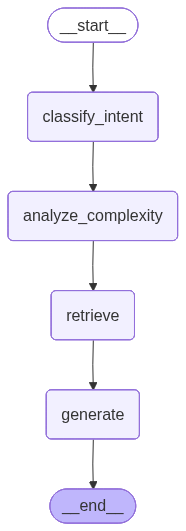

In [20]:
# ============================================================================
# Agentic RAG 구현 - Step 3: LangGraph 그래프 구성
# ============================================================================

# 그래프 생성
agentic_rag_graph = StateGraph(state_schema=AgenticRAGState)

# 노드 추가
agentic_rag_graph.add_node("classify_intent", intent_classification_node)
agentic_rag_graph.add_node("analyze_complexity", complexity_analysis_node)
agentic_rag_graph.add_node("retrieve", adaptive_retrieval_node)
agentic_rag_graph.add_node("generate", generation_node)

# 엣지 정의 (순차적 실행)
agentic_rag_graph.set_entry_point("classify_intent")
agentic_rag_graph.add_edge("classify_intent", "analyze_complexity")
agentic_rag_graph.add_edge("analyze_complexity", "retrieve")
agentic_rag_graph.add_edge("retrieve", "generate")
agentic_rag_graph.add_edge("generate", END)

# 그래프 컴파일
agentic_rag_app = agentic_rag_graph.compile()
agentic_rag_app

### 다양한 질문으로 Agentic RAG 테스트

이제 구축한 Agentic RAG 시스템을 다양한 도메인의 질문으로 테스트해봅시다.


In [ ]:
# ============================================================================
# Agentic RAG 테스트 - 혼합 도메인 질문
# ============================================================================

# 테스트 질문들 (금융/법률/기술 혼합)
test_questions = [
    {
        "domain": "금융",
        "query": "2024년 삼성전자의 영업이익률은 얼마인가?",
        "expected_complexity": "SIMPLE",
        "expected_intent": "CALCULATE",
    },
    {
        "domain": "법률",
        "query": "근로기준법 제60조에서 정한 연장근로 시간의 상한은?",
        "expected_complexity": "SIMPLE",
        "expected_intent": "SEARCH",
    },
    {
        "domain": "기술",
        "query": "React 18의 Concurrent Rendering이란 무엇이고, 기존 버전과 어떤 차이가 있나?",
        "expected_complexity": "MEDIUM",
        "expected_intent": "EXPLAIN",
    },
]

print("=" * 80)
print("Agentic RAG 테스트 시작")
print("=" * 80)

# 각 질문에 대해 RAG 실행
for i, test_case in enumerate(test_questions, 1):
    print(f"\n{'=' * 80}")
    print(f"[테스트 {i}/{len(test_questions)}] {test_case['domain']} 도메인")
    print(f"{'=' * 80}")
    print(f"질문: {test_case['query']}")
    print(f"예상 복잡도: {test_case['expected_complexity']}")
    print(f"예상 의도: {test_case['expected_intent']}")
    print()

    try:
        # Agentic RAG 실행
        result = agentic_rag_app.invoke({"query": test_case["query"]})

        # 결과 출력
        print(f"\n{'─' * 80}")
        print(f"실행 결과:")
        print(f"{'─' * 80}")
        print(f"✓ 의도: {result.get('intent', 'N/A')} (예상: {test_case['expected_intent']})")
        print(
            f"✓ 복잡도: {result.get('complexity', 'N/A')} (예상: {test_case['expected_complexity']})"
        )
        print(f"✓ 검색 전략: {result.get('retrieval_strategy', 'N/A')}")
        print(f"✓ 검색된 문서 수: {len(result.get('retrieved_docs', []))}개")

        answer = result.get("answer", "")
        print(f"\n✓ 생성된 답변:")
        print(f"{answer}")

        # 예측 정확도 체크
        correct_intent = result.get("intent") == test_case["expected_intent"]
        correct_complexity = result.get("complexity") == test_case["expected_complexity"]

        print(f"\n✓ 분류 정확도:")
        print(f"  - 의도 분류: {' 정확' if correct_intent else '❌ 불일치'}")
        print(f"  - 복잡도 분류: {' 정확' if correct_complexity else '❌ 불일치'}")

    except Exception as e:
        print(f"\n 실행 중 오류 발생: {e}")
        import traceback

        traceback.print_exc()

print("""
[관찰 포인트]

1. **Intent Classification**
   - 각 질문의 의도를 정확히 파악했는가?
   - SEARCH/EXPLAIN/CALCULATE 등이 올바르게 분류되었는가?

2. **Complexity Analysis**
   - 질문의 복잡도를 적절히 판단했는가?
   - 단순 질문은 SIMPLE, 비교/추론 질문은 MEDIUM/COMPLEX로 분류되었는가?

3. **Adaptive Retrieval**
   - 복잡도에 따라 검색 전략이 달라졌는가?
   - SIMPLE: top_k=3, MEDIUM: top_k=5, COMPLEX: top_k=10

4. **Answer Quality**
   - 생성된 답변이 질문에 직접 답하는가?
   - 컨텍스트에 충실한 답변인가? (환각 없음)
""")

---

## 3. Agentic RAG Workflow에 RAGAS 평가 추가하기

### 3.1 평가 데이터셋 준비

RAGAS 평가를 위해서는 다음이 필요합니다:
1. **질문 (Question)**: 평가할 질문
2. **Ground Truth**: 정답 (참조 답변)
3. **생성된 답변 (Answer)**: RAG 시스템이 생성한 답변  
4. **검색된 컨텍스트 (Contexts)**: RAG가 검색한 문서들

우리는 수동으로 작성한 평가 질문 세트를 사용합니다.  
**Q. 실무에서는 수동 / 자동 얼마나 섞어야 할까요?**

In [15]:
# ============================================================================
# 평가 데이터셋 준비
# ============================================================================

# 혼합 도메인 평가 질문 세트 (금융/법률/기술)
evaluation_questions = [
    # 금융 도메인
    EvaluationQuestion(
        id="Q001",
        question="Python에서 리스트 컴프리헨션이란 무엇인가요?",
        question_type=QuestionType.EXPLAIN,
        difficulty=DifficultyLevel.SIMPLE,
        ground_truth="리스트 컴프리헨션은 기존 리스트를 기반으로 새로운 리스트를 간결하게 생성하는 파이썬 문법입니다. [표현식 for 항목 in 반복가능객체] 형태로 작성되며, 조건을 추가할 수도 있습니다.",
        relevant_doc_ids=["python_basics_001"],
        metadata={"domain": "기술", "source": "manual"},
    ),
    EvaluationQuestion(
        id="Q002",
        question="함수형 프로그래밍의 주요 특징은 무엇인가요?",
        question_type=QuestionType.EXPLAIN,
        difficulty=DifficultyLevel.MEDIUM,
        ground_truth="함수형 프로그래밍의 주요 특징은 불변성(immutability), 순수 함수(pure functions), 고차 함수(higher-order functions), 선언적 프로그래밍 스타일입니다.",
        relevant_doc_ids=["fp_basics_001", "fp_basics_002"],
        metadata={"domain": "기술", "source": "manual"},
    ),
    EvaluationQuestion(
        id="Q003",
        question="RESTful API의 설계 원칙은 무엇인가요?",
        question_type=QuestionType.EXPLAIN,
        difficulty=DifficultyLevel.SIMPLE,
        ground_truth="RESTful API의 주요 설계 원칙은 1) 자원(Resource)의 식별, 2) HTTP 메서드 활용, 3) 무상태성(Stateless), 4) 캐시 가능성, 5) 계층화된 시스템입니다.",
        relevant_doc_ids=["rest_api_001"],
        metadata={"domain": "기술", "source": "manual"},
    ),
]

# 평가 데이터셋 생성
eval_dataset = EvaluationDataset(
    name="Mixed_Domain_Evaluation_v1",
    description="금융/법률/기술 혼합 도메인 평가 데이터셋 (수동 작성)",
    version="1.0.0",
    questions=evaluation_questions,
    metadata={
        "creation_method": "manual",
        "num_domains": 3,
        "author": "SDS Class Day2",
    },
)

print("\n평가 데이터셋 준비 완료")
print(f"  - 총 질문 수: {len(eval_dataset.questions)}개")
print(f"  - 도메인: {len(set(q.metadata.get('domain') for q in eval_dataset.questions))}개")

# 질문 미리보기
print("\n질문 미리보기:")
for q in eval_dataset.questions:
    print(f"  [{q.id}] ({q.metadata.get('domain')}) {q.question[:50]}...")


AttributeError: EXPLAIN

In [ ]:
# ============================================================================
# RAGAS 평가 실행
# ============================================================================
# RAGAS 평가 결과를 저장할 리스트
ragas_results = []

# 각 질문에 대해 RAG 실행 및 평가
for i, question in enumerate(eval_dataset.questions, 1):
    print(f"\n[{i}/{len(eval_dataset.questions)}] {question.id}: {question.question[:50]}...")

    try:
        # Step 1: Agentic RAG 실행
        rag_result = agentic_rag_app.invoke({"query": question.question})
        answer = rag_result.get("answer", "")
        contexts = rag_result.get("retrieved_docs", [])

        print(f"  ✓ RAG 실행 완료 ({len(contexts)}개 문서 검색)")

        # Step 2: RAGAS 평가 데이터 생성
        sample = SingleTurnSample(
            user_input=question.question,
            response=answer,
            retrieved_contexts=contexts,
            reference=question.ground_truth,
        )

        # Step 3: RAGAS 평가 실행
        # 참고: 실제 환경에서는 evaluate()로 배치 평가하는 것이 효율적
        # 여기서는 개별 평가 시연
        eval_data = EvaluationDataset(samples=[sample])

        result = evaluate(
            dataset=eval_data,
            metrics=[context_precision, context_recall, faithfulness, answer_relevancy],
            llm=llm,
            embeddings=embeddings,
        )

        ragas_results.append(
            {
                "question_id": question.id,
                "question": question.question,
                "answer": answer,
                "contexts": contexts,
                "ground_truth": question.ground_truth,
                "context_precision": result["context_precision"],
                "context_recall": result["context_recall"],
                "faithfulness": result["faithfulness"],
                "answer_relevancy": result["answer_relevancy"],
                "avg_score": sum(
                    [
                        result["context_precision"],
                        result["context_recall"],
                        result["faithfulness"],
                        result["answer_relevancy"],
                    ]
                )
                / 4,
            }
        )

        print(f"  ✓ RAGAS 평가 완료 (평균: {ragas_results[-1]['avg_score']:.3f})")

    except Exception as e:
        print(f" 평가 실패: {e}")

# 전체 평균 계산
avg_precision = sum(r["context_precision"] for r in ragas_results) / len(ragas_results)
avg_recall = sum(r["context_recall"] for r in ragas_results) / len(ragas_results)
avg_faithfulness = sum(r["faithfulness"] for r in ragas_results) / len(ragas_results)
avg_relevancy = sum(r["answer_relevancy"] for r in ragas_results) / len(ragas_results)
avg_overall = sum(r["avg_score"] for r in ragas_results) / len(ragas_results)

print("전체 평균 점수:")
print(f"  • Context Precision  : {avg_precision:.3f}")
print(f"  • Context Recall     : {avg_recall:.3f}")
print(f"  • Faithfulness       : {avg_faithfulness:.3f}")
print(f"  • Answer Relevancy   : {avg_relevancy:.3f}")
print(f"  • 전체 평균          : {avg_overall:.3f}")

## 4. RAGAS 평가 결과 해석하기

평가 결과를 분석하고 개선 포인트를 파악합니다.


In [ ]:
# ============================================================================
# Section 4: RAGAS 평가 결과 심층 해석
# ============================================================================

# ----------------------------------------------------------------------------
# 4.1 전체 평균 점수 해석
# ----------------------------------------------------------------------------

print("\n[전체 평균 점수]")
print(f"  • Context Precision  : {avg_precision:.3f}")
print(f"  • Context Recall     : {avg_recall:.3f}")
print(f"  • Faithfulness       : {avg_faithfulness:.3f}")
print(f"  • Answer Relevancy   : {avg_relevancy:.3f}")
print(f"  • 전체 평균          : {avg_overall:.3f}")

# 등급 판정
if avg_overall >= 0.85:
    grade = "EXCELLENT - 프로덕션 배포 가능"
elif avg_overall >= 0.70:
    grade = "GOOD - 일부 개선 후 배포 권장"
elif avg_overall >= 0.55:
    grade = "FAIR - 상당한 개선 필요"
else:
    grade = "POOR - 근본적 재설계 필요"

print(f"\n전체 평가: {grade}")

# ----------------------------------------------------------------------------
# 4.2 개별 지표 상세 분석
# ----------------------------------------------------------------------------

# 각 지표별 해석
metrics_analysis = {
    "Context Precision": {
        "score": avg_precision,
        "description": "검색된 문서의 관련성",
        "good_threshold": 0.80,
        "problem": "무관한 문서 혼입",
        "impact": "토큰 낭비, 답변 품질 저하",
    },
    "Context Recall": {
        "score": avg_recall,
        "description": "필요한 정보 검색 정도",
        "good_threshold": 0.75,
        "problem": "필요한 정보 누락",
        "impact": '"모르겠다" 답변, 부정확한 추론',
    },
    "Faithfulness": {
        "score": avg_faithfulness,
        "description": "컨텍스트 충실도",
        "good_threshold": 0.90,
        "problem": "환각 (Hallucination)",
        "impact": "사용자 신뢰 상실, 잘못된 의사결정",
    },
    "Answer Relevancy": {
        "score": avg_relevancy,
        "description": "질문-답변 일치도",
        "good_threshold": 0.80,
        "problem": "질문 의도 불일치",
        "impact": "사용자 불만, 재질문 증가",
    },
}

for metric_name, info in metrics_analysis.items():
    print(f"\n• {metric_name}: {info['score']:.3f}")
    print(f"  - 측정 대상: {info['description']}")

    if info["score"] >= info["good_threshold"]:
        print(f"  - 상태: 양호 (임계값 {info['good_threshold']:.2f} 이상)")
    else:
        print(f"  - 상태: 개선 필요 (임계값 {info['good_threshold']:.2f} 미만)")
        print(f"  - 문제: {info['problem']}")
        print(f"  - 영향: {info['impact']}")

# ----------------------------------------------------------------------------
# 4.3 실패 케이스 상세 분석
# ----------------------------------------------------------------------------
# 점수가 낮은 상위 2개 질문
worst_questions = sorted(ragas_results, key=lambda x: x["avg_score"])[:2]

for i, result in enumerate(worst_questions, 1):
    print(f"\n{'=' * 60}")
    print(f"실패 케이스 {i}: {result['question_id']}")
    print(f"{'=' * 60}")

    print("\n질문:")
    print(f"  {result['question']}")

    print("\n점수:")
    print(f"  - 평균: {result['avg_score']:.3f}")
    print(f"  - Context Precision: {result['context_precision']:.3f}")
    print(f"  - Context Recall: {result['context_recall']:.3f}")
    print(f"  - Faithfulness: {result['faithfulness']:.3f}")
    print(f"  - Answer Relevancy: {result['answer_relevancy']:.3f}")

    # 가장 낮은 지표 식별
    metrics = {
        "Context Precision": result["context_precision"],
        "Context Recall": result["context_recall"],
        "Faithfulness": result["faithfulness"],
        "Answer Relevancy": result["answer_relevancy"],
    }
    worst_metric = min(metrics, key=metrics.get)
    worst_score = metrics[worst_metric]

    print(f"\n병목 지표: {worst_metric} ({worst_score:.3f})")

    # 노드별 진단
    if "Precision" in worst_metric:
        problem_node = "Reranking"
        diagnosis = "무관한 문서가 많이 혼입됨"
        action = "• Reranker 모델 추가 (cross-encoder)\n      • top_k 감소 (10→5)\n      • MMR 적용"
    elif "Recall" in worst_metric:
        problem_node = "Retrieval"
        diagnosis = "필요한 문서를 충분히 검색하지 못함"
        action = (
            "• top_k 증가 (5→20)\n      • chunk_overlap 증가 (10%→20%)\n      • 임베딩 모델 변경"
        )
    elif "Faithfulness" in worst_metric:
        problem_node = "Generation"
        diagnosis = "LLM이 환각을 생성함"
        action = "• 프롬프트 강화 (컨텍스트만 사용)\n      • Temperature: 0.7→0.0\n      • Few-shot 예제 추가"
    else:
        problem_node = "Query Transform"
        diagnosis = "질문 의도를 정확히 파악하지 못함"
        action = "• HyDE 노드 추가\n      • Query Rewrite 개선\n      • Intent Classification 강화"

    print(f"  → 문제 노드: {problem_node}")
    print(f"  → 진단: {diagnosis}")
    print("  → 권장 액션:")
    print(f"      {action}")

    # 검색된 컨텍스트 미리보기
    print(f"\n검색된 컨텍스트: {len(result['contexts'])}개")
    for j, ctx in enumerate(result["contexts"][:2], 1):
        preview = ctx[:100].replace("\n", " ")
        print(f"  [{j}] {preview}...")

    # 생성된 답변
    print("\n생성된 답변:")
    answer_preview = result["answer"][:200].replace("\n", " ")
    print(f"  {answer_preview}...")

    # Ground Truth와 비교
    print("\nGround Truth:")
    gt_preview = result["ground_truth"][:200].replace("\n", " ")
    print(f"  {gt_preview}...")

## 5. RAGAS 평가 결과에 따른 개선 방향성 및 전략 수립

### 5.1 노드별 개선 액션 매핑

RAGAS 지표와 RAG 노드를 매핑하여 자동으로 개선 전략을 수립합니다.

In [ ]:
# ============================================================================
# Section 5: 자동 개선 계획 생성
# ============================================================================

print("=" * 80)
print("Section 5: 자동 개선 계획 생성 - 노드별 액션 매핑")
print("=" * 80)

from datetime import datetime

from eval.auto_improve import ActionPriority, AutoImprovementEngine
from eval.ragas_evaluation import RAGASEvaluationReport

# ----------------------------------------------------------------------------
# 5.1 평가 리포트 생성
# ----------------------------------------------------------------------------

print("\n[Step 1] 평가 리포트 생성")

report = RAGASEvaluationReport(
    pipeline_name="Agentic RAG v1",
    dataset_name=eval_dataset.name,
    num_questions=len(ragas_results),
    avg_context_precision=avg_precision,
    avg_context_recall=avg_recall,
    avg_faithfulness=avg_faithfulness,
    avg_answer_relevancy=avg_relevancy,
    avg_overall=avg_overall,
    timestamp=datetime.now().isoformat(),
    metadata={"model": llm.model_name if hasattr(llm, "model_name") else "unknown"},
)

print(f"  - Pipeline: {report.pipeline_name}")
print(f"  - 평균 점수: {report.avg_overall:.3f}")

# ----------------------------------------------------------------------------
# 5.2 자동 개선 엔진으로 개선 계획 생성
# ----------------------------------------------------------------------------

engine = AutoImprovementEngine()
improvement_plan = engine.analyze_and_generate_plan(report)

print(f"  - 총 액션 수: {len(improvement_plan.actions)}개")
print(
    f"  - 예상 개선폭: {improvement_plan.expected_overall_improvement:+.3f} ({improvement_plan.expected_overall_improvement / avg_overall:+.1%})"
)

# ----------------------------------------------------------------------------
# 5.3 노드-지표-액션 매핑 테이블
# ----------------------------------------------------------------------------

print("\n[Step 3] 노드별 개선 액션 매핑 테이블")
print(f"{'=' * 80}")

if improvement_plan.actions:
    # 노드별 그룹화
    from collections import defaultdict

    actions_by_node = defaultdict(list)

    for action in improvement_plan.actions:
        actions_by_node[action.target_node.value].append(action)

    print("\n노드별 개선 액션:")
    for node_name, actions in actions_by_node.items():
        print(f"\n🔹 {node_name.upper()} 노드 ({len(actions)}개 액션)")

        for i, action in enumerate(actions, 1):
            priority_emoji = {
                "critical": "🔴",
                "high": "🟠",
                "medium": "🟡",
                "low": "🟢",
            }[action.priority.value]

            print(f"\n  {priority_emoji} [{i}] {action.description}")
            print(f"      목표 지표: {action.target_metric.value}")
            print(f"      우선순위: {action.priority.value.upper()}")
            print(f"      근거: {action.rationale[:80]}...")
            print(f"      예상 효과: {action.expected_metric_improvement:+.2%}")
            print("\n      파라미터 변경:")
            for key, value in action.parameter_changes.items():
                print(f"        - {key}: {value}")

            print("\n      비용/성능 영향:")
            print(f"        - 비용 영향: {action.cost_impact}")
            print(f"        - 지연시간 영향: {action.latency_impact}")

            if action.expected_side_effects:
                print("\n      주의사항:")
                for effect in action.expected_side_effects[:2]:
                    print(f"        - {effect}")

# ----------------------------------------------------------------------------
# 5.4 우선순위별 필터링
# ----------------------------------------------------------------------------

# CRITICAL + HIGH 우선순위만
high_priority_actions = improvement_plan.filter_by_priority(ActionPriority.HIGH)

print(f"\n최우선 적용 대상 (CRITICAL + HIGH): {len(high_priority_actions)}개")

for i, action in enumerate(high_priority_actions, 1):
    print(f"\n{i}. {action.description}")
    print(f"   - 노드: {action.target_node.value}")
    print(f"   - 지표: {action.target_metric.value}")
    print(f"   - 예상 효과: {action.expected_metric_improvement:+.2%}")


## 6. RAG Workflow 자동 개선 구조 설계 및 A/B 테스트

실제로 개선안을 적용하고 효과를 측정하는 방법을 실습합니다.


In [ ]:
# ============================================================================
# Section 6: RAG Workflow 자동 개선 구조 - A/B 테스트
# ============================================================================

print("=" * 80)
print("Section 6: RAG Workflow 자동 개선 - A/B 테스트")
print("=" * 80)

# ----------------------------------------------------------------------------
# 6.1 Baseline 설정 저장
# ----------------------------------------------------------------------------

print("\n[Step 1] Baseline 설정 저장")

# 현재 설정을 config_v1으로 저장
config_v1 = {
    "name": "Baseline (v1)",
    "retrieval": {
        "top_k": 3,  # SIMPLE 기준
        "search_strategy": "vector_search",
    },
    "generation": {
        "temperature": 0.3,
        "max_tokens": 4096,
        "system_prompt": GENERATION_PROMPT,
    },
    "metadata": {
        "avg_score": avg_overall,
        "timestamp": datetime.now().isoformat(),
    },
}

print("✓ Baseline 설정 저장 완료")
print(f"  - Retrieval top_k: {config_v1['retrieval']['top_k']}")
print(f"  - Generation temperature: {config_v1['generation']['temperature']}")
print(f"  - Baseline 점수: {config_v1['metadata']['avg_score']:.3f}")

# ----------------------------------------------------------------------------
# 6.2 개선안 적용 (config_v2 생성)
# ----------------------------------------------------------------------------

print("\n[Step 2] 개선안 적용")

# 최우선 액션들을 적용한 새로운 설정
config_v2 = {
    "name": "Improved (v2)",
    "retrieval": {
        "top_k": 10,  # Context Recall 개선: 3 → 10
        "search_strategy": "hybrid_search",  # Context Precision 개선
    },
    "generation": {
        "temperature": 0.0,  # Faithfulness 개선: 0.3 → 0.0
        "max_tokens": 4096,
        "system_prompt": """당신은 정확하고 신뢰할 수 있는 AI 어시스턴트입니다.

**중요 규칙:**
1. 제공된 정보에 없는 정보는 절대 만들지 마세요 (환각 금지)
2. 컨텍스트만으로 답변이 불가능하면 "제공된 정보만으로는 답변하기 어렵습니다"라고 명확히 말하세요
3. 답변은 간결하고 명확하게 작성하세요
4. 가능하면 컨텍스트의 표현을 그대로 사용하세요

질문: {query}

컨텍스트:
{context}

답변:""",  # 프롬프트 강화
    },
    "metadata": {
        "improvements_applied": [
            "top_k 증가 (3→10) for Context Recall",
            "Temperature 감소 (0.3→0.0) for Faithfulness",
            "프롬프트 강화 for Faithfulness",
        ],
        "expected_improvement": improvement_plan.expected_overall_improvement,
        "timestamp": datetime.now().isoformat(),
    },
}

print(
    f"  - Retrieval top_k: {config_v2['retrieval']['top_k']} (↑ {config_v2['retrieval']['top_k'] - config_v1['retrieval']['top_k']})"
)
print(
    f"  - Generation temperature: {config_v2['generation']['temperature']} (↓ {config_v1['generation']['temperature'] - config_v2['generation']['temperature']})"
)
print(f"  - 적용된 개선 사항: {len(config_v2['metadata']['improvements_applied'])}개")

# ----------------------------------------------------------------------------
# 6.3 A/B 테스트 시뮬레이션
# ----------------------------------------------------------------------------

print("\n[Step 3] A/B 테스트 시뮬레이션")
print(f"{'─' * 80}")

print("""
💡 실제 A/B 테스트 프로세스:

1. **동일 데이터셋 사용**
   - Baseline (v1)과 Improved (v2)를 동일한 평가 질문으로 테스트
   - 공정한 비교를 위해 동일한 조건 유지

2. **병렬 실행**
   - 두 설정을 동시에 실행하여 시간 요인 제거
   - 각각 독립적인 RAG 파이프라인 생성

3. **지표별 비교**
   - Context Precision, Recall, Faithfulness, Relevancy 개별 비교
   - 통계적 유의성 검증 (t-test 등)

4. **비용/성능 분석**
   - 토큰 사용량 비교
   - 응답 시간 비교
   - 비용 대비 효과 분석

5. **배포 결정**
   - 개선폭 > 5%p AND 부작용 없음 → 배포
   - 개선폭 < 5%p → 추가 개선 시도
   - 부작용 있음 → 롤백 후 재검토
""")

# Context Recall 개선 (+15%p 예상)
expected_recall_v2 = min(1.0, avg_recall + 0.15)

# Faithfulness 개선 (+10%p 예상)
expected_faithfulness_v2 = min(1.0, avg_faithfulness + 0.10)

# Context Precision은 유지 또는 소폭 감소 가능 (top_k 증가로 인해)
expected_precision_v2 = max(0, avg_precision - 0.03)

# Answer Relevancy는 유지
expected_relevancy_v2 = avg_relevancy

# 전체 평균
expected_overall_v2 = (
    expected_precision_v2 + expected_recall_v2 + expected_faithfulness_v2 + expected_relevancy_v2
) / 4

print("\nBaseline (v1) vs Improved (v2) 예상 점수:")
print(f"{'─' * 80}")
print(f"{'지표':<20} {'Baseline':>12} {'Improved':>12} {'변화량':>12}")
print(f"{'─' * 80}")
print(
    f"{'Context Precision':<20} {avg_precision:>12.3f} {expected_precision_v2:>12.3f} {expected_precision_v2 - avg_precision:>+12.3f}"
)
print(
    f"{'Context Recall':<20} {avg_recall:>12.3f} {expected_recall_v2:>12.3f} {expected_recall_v2 - avg_recall:>+12.3f}"
)
print(
    f"{'Faithfulness':<20} {avg_faithfulness:>12.3f} {expected_faithfulness_v2:>12.3f} {expected_faithfulness_v2 - avg_faithfulness:>+12.3f}"
)
print(
    f"{'Answer Relevancy':<20} {avg_relevancy:>12.3f} {expected_relevancy_v2:>12.3f} {expected_relevancy_v2 - avg_relevancy:>+12.3f}"
)
print(f"{'─' * 80}")
print(
    f"{'전체 평균':<20} {avg_overall:>12.3f} {expected_overall_v2:>12.3f} {expected_overall_v2 - avg_overall:>+12.3f}"
)
print(f"{'=' * 80}")

# 개선 효과 평가
improvement_pct = ((expected_overall_v2 - avg_overall) / avg_overall) * 100

print("\n개선 효과:")
print(f"  - 절대 개선폭: {expected_overall_v2 - avg_overall:+.3f}점")
print(f"  - 상대 개선률: {improvement_pct:+.1f}%")

if improvement_pct >= 5:
    print("  - 판정:  배포 권장 (5% 이상 개선)")
elif improvement_pct >= 2:
    print("  - 판정: 🟡 조건부 배포 (2-5% 개선, 추가 검증 필요)")
else:
    print("  - 판정: ❌ 배포 보류 (2% 미만 개선, 추가 개선 필요)")

# ----------------------------------------------------------------------------
# 6.4 실제 적용 시 주의사항
# ----------------------------------------------------------------------------

"""
1. 카나리 배포 (Canary Deployment)
   - 특정 사용자 그룹에게만 먼저 적용
   - 내부 테스터 → 파워 유저 → 일반 사용자

2. 모니터링 지표
   - RAGAS 점수 (주기적 평가)
   - 사용자 만족도 (피드백 점수)
   - 응답 시간 (지연시간 증가 확인)
   - 오류율 (환각 발생 빈도)

3. 롤백 계획
   - 1분 내 롤백 가능한 구조
   - 이전 Configuration 으로 즉시 복원 가능하도록
   - 롤백 시나리오 사전 테스트

4. 지속적 개선
   - 주 1회 RAGAS 평가
   - 신규 실패 케이스 수집
   - 분기별 대규모 개선
"""

Section 6: RAG Workflow 자동 개선 - A/B 테스트

[Step 1] Baseline 설정 저장


NameError: name 'avg_overall' is not defined

## 7. Ground Truth 데이터셋 구축 실전 가이드

### 7.1 3가지 데이터셋 구축 방법

실무에서 활용 가능한 3가지 Ground Truth 구축 방법을 실습합니다.


In [16]:
"""평가 데이터셋 구축 프레임워크.

실무에서 RAG 시스템을 평가하기 위한 데이터셋을 구축하는 3가지 방법을 제공합니다:
1. 실제 사용자 질문 수집 (Production 로그 기반)
2. 도메인 전문가 인터뷰 (SME - Subject Matter Expert)
3. LLM 기반 합성 데이터 생성 + 검증

References:
- Anthropic: "Building Effective Agents" - Evaluation Best Practices
- OpenAI: "Evals" Framework
- DeepEval: Dataset Generation Patterns
"""

import json
from enum import Enum
from pathlib import Path
from typing import Any, Literal

from langchain_core.documents import Document
from langchain_core.language_models import BaseChatModel
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

logger = print("dataset_builder")


# ============================================================================
# 데이터 모델 정의
# ============================================================================


class QuestionType(str, Enum):
    """질문 유형 분류.

    실무 가이드:
    - FACTUAL: 단순 사실 확인 (예: "2024년 매출액은?")
    - REASONING: 추론 필요 (예: "매출 증가 원인은?")
    - COMPARISON: 비교/대조 (예: "전년 대비 차이는?")
    - CALCULATION: 계산 필요 (예: "영업이익률은?")
    - AGGREGATION: 여러 정보 종합 (예: "주요 리스크 요인들은?")
    """

    FACTUAL = "factual"
    REASONING = "reasoning"
    COMPARISON = "comparison"
    EXPLAIN = "explain"
    CALCULATION = "calculation"
    AGGREGATION = "aggregation"


class DifficultyLevel(str, Enum):
    """난이도 레벨.

    - SIMPLE: 단일 문서 내 직접 답변 가능 (1-hop)
    - MEDIUM: 2-3개 문서 조합 필요 (2-hop)
    - COMPLEX: 4개 이상 문서 + 복잡한 추론 (multi-hop)
    """

    SIMPLE = "simple"
    MEDIUM = "medium"
    COMPLEX = "complex"


class EvaluationQuestion(BaseModel):
    """평가용 질문 단위."""

    id: str = Field(description="질문 고유 ID (예: Q001)")
    question: str = Field(description="사용자 질문")
    question_type: QuestionType = Field(description="질문 유형")
    difficulty: DifficultyLevel = Field(description="난이도")

    ground_truth: str = Field(description="정답 (Ground Truth)")
    relevant_doc_ids: list[str] = Field(
        default_factory=list, description="관련 문서 ID 리스트 (Context Recall 계산용)"
    )

    metadata: dict[str, Any] = Field(
        default_factory=dict, description="추가 메타데이터 (도메인, 작성자, 검증 상태 등)"
    )


class EvaluationDataset(BaseModel):
    """평가 데이터셋 전체 구조."""

    name: str = Field(description="데이터셋 이름")
    description: str = Field(description="데이터셋 설명")
    version: str = Field(default="1.0.0")

    questions: list[EvaluationQuestion] = Field(default_factory=list)

    metadata: dict[str, Any] = Field(
        default_factory=dict, description="데이터셋 메타데이터 (생성 방법, 검증자 등)"
    )

    def save_to_json(self, path: Path) -> None:
        """JSON 파일로 저장."""
        path.parent.mkdir(parents=True, exist_ok=True)
        with path.open("w", encoding="utf-8") as f:
            import json

            data = self.model_dump()
            f.write(json.dumps(data, indent=2, ensure_ascii=False))
        logger.info(f"Saved dataset to {path}")

    @classmethod
    def load_from_json(cls, path: Path) -> EvaluationDataset:
        """JSON 파일에서 로드."""
        with path.open("r", encoding="utf-8") as f:
            data = json.load(f)
        return cls(**data)

    def get_questions_by_type(self, question_type: QuestionType) -> list[EvaluationQuestion]:
        """특정 유형의 질문만 필터링."""
        return [q for q in self.questions if q.question_type == question_type]

    def get_questions_by_difficulty(self, difficulty: DifficultyLevel) -> list[EvaluationQuestion]:
        """특정 난이도의 질문만 필터링."""
        return [q for q in self.questions if q.difficulty == difficulty]


# ============================================================================
# LLM 기반 합성 데이터 생성
# ============================================================================


class SyntheticQuestion(BaseModel):
    """LLM이 생성한 질문."""

    question: str = Field(description="생성된 질문")
    question_type: QuestionType = Field(description="질문 유형")
    difficulty: DifficultyLevel = Field(description="난이도")
    ground_truth: str = Field(description="예상 정답")
    reasoning: str = Field(description="이 질문을 생성한 이유/의도")


class SyntheticDatasetGenerator:
    """LLM 기반 합성 데이터셋 생성기.

    실무 노하우:
    1. 실제 문서에서 샘플링한 컨텍스트 기반으로 생성
    2. 다양한 난이도와 질문 유형 골고루 생성
    3. Ground Truth는 문서 내용 기반으로 검증 가능하게
    4. 생성 후 반드시 도메인 전문가 검증 필요
    """

    GENERATION_PROMPT = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """당신은 RAG 시스템 평가를 위한 고품질 질문을 생성하는 전문가입니다.

주어진 문서 컨텍스트를 읽고, 다음 기준에 맞는 평가 질문을 생성하세요:

**질문 유형:**
- factual: 단순 사실 확인
- reasoning: 추론이 필요한 질문
- comparison: 비교/대조
- calculation: 계산이 필요한 질문
- aggregation: 여러 정보를 종합해야 하는 질문

**난이도:**
- simple: 주어진 컨텍스트에서 직접 답변 가능
- medium: 컨텍스트의 2-3개 부분을 조합해야 답변 가능
- complex: 깊은 추론과 여러 정보 종합 필요

**중요:**
- Ground Truth는 주어진 컨텍스트에서 직접 추출 가능해야 함
- 질문은 명확하고 구체적이어야 함
- 실제 사용자가 물을 법한 자연스러운 질문이어야 함

{format_instructions}""",
            ),
            (
                "user",
                """문서 컨텍스트:
---
{context}
---

요청 사항:
- 질문 유형: {question_type}
- 난이도: {difficulty}

위 컨텍스트를 기반으로 고품질 평가 질문 1개를 생성하세요.""",
            ),
        ]
    )

    def __init__(self, llm: BaseChatModel):
        """초기화.

        Args:
            llm: 질문 생성에 사용할 LLM
        """
        self.llm = llm
        self.parser = PydanticOutputParser(pydantic_object=SyntheticQuestion)

    def generate_question(
        self,
        context: str,
        question_type: QuestionType,
        difficulty: DifficultyLevel,
    ) -> SyntheticQuestion:
        """단일 질문 생성.

        Args:
            context: 문서 컨텍스트
            question_type: 생성할 질문 유형
            difficulty: 난이도

        Returns:
            생성된 질문
        """
        prompt = self.GENERATION_PROMPT.format_messages(
            context=context,
            question_type=question_type.value,
            difficulty=difficulty.value,
            format_instructions=self.parser.get_format_instructions(),
        )

        response = self.llm.invoke(prompt)
        return self.parser.parse(response.content)

    def generate_dataset(
        self,
        documents: list[Document],
        num_questions_per_type: int = 2,
        num_questions_per_difficulty: int = 3,
    ) -> EvaluationDataset:
        """문서 집합으로부터 데이터셋 생성.

        Args:
            documents: 소스 문서 리스트
            num_questions_per_type: 각 질문 유형당 생성할 개수
            num_questions_per_difficulty: 각 난이도당 생성할 개수

        Returns:
            생성된 평가 데이터셋
        """
        dataset = EvaluationDataset(
            name="synthetic_evaluation_dataset",
            description="LLM 기반 자동 생성된 평가 데이터셋",
            metadata={
                "generation_method": "llm_synthetic",
                "llm_model": getattr(self.llm, "model_name", "unknown"),
                "num_source_documents": len(documents),
            },
        )

        question_id = 1

        # 난이도별로 고르게 분포
        for difficulty in DifficultyLevel:
            for question_type in QuestionType:
                for _ in range(num_questions_per_type):
                    try:
                        # 랜덤하게 문서 선택
                        import random

                        doc = random.choice(documents)

                        synthetic_q = self.generate_question(
                            context=doc.page_content,
                            question_type=question_type,
                            difficulty=difficulty,
                        )

                        eval_q = EvaluationQuestion(
                            id=f"Q{question_id:03d}",
                            question=synthetic_q.question,
                            question_type=synthetic_q.question_type,
                            difficulty=synthetic_q.difficulty,
                            ground_truth=synthetic_q.ground_truth,
                            relevant_doc_ids=[doc.metadata.get("id", f"doc_{question_id}")],
                            metadata={
                                "generation_method": "llm_synthetic",
                                "reasoning": synthetic_q.reasoning,
                            },
                        )

                        dataset.questions.append(eval_q)
                        question_id += 1

                        logger.info(
                            f"Generated Q{question_id - 1:03d}: "
                            f"{question_type.value}/{difficulty.value}"
                        )

                    except Exception as e:
                        logger.warning(f"Failed to generate question: {e}")
                        continue

        return dataset


# ============================================================================
# 도메인 전문가 인터뷰 기반 데이터셋 구축
# ============================================================================


class SMEDatasetBuilder:
    """도메인 전문가(SME) 인터뷰 기반 데이터셋 구축 도구.

    실무 프로세스:
    1. 도메인 전문가에게 실제 업무에서 자주 하는 질문 수집
    2. 각 질문에 대한 정확한 답변과 근거 문서 요청
    3. 난이도와 질문 유형 분류
    4. 검증 프로세스: 다른 전문가가 답변 확인

    템플릿 제공:
    - Excel/CSV 템플릿으로 전문가가 직접 작성 가능
    - 작성 가이드라인 문서 제공
    """

    @staticmethod
    def create_template() -> dict[str, Any]:
        """전문가용 템플릿 생성.

        Returns:
            템플릿 구조 (CSV/Excel 변환 가능)
        """
        return {
            "columns": [
                "질문 ID",
                "질문",
                "질문 유형 (factual/reasoning/comparison/calculation/aggregation)",
                "난이도 (simple/medium/complex)",
                "정답",
                "관련 문서 ID (쉼표로 구분)",
                "비고",
            ],
            "example_rows": [
                {
                    "질문 ID": "Q001",
                    "질문": "2024년 연결 매출액은 얼마입니까?",
                    "질문 유형": "factual",
                    "난이도": "simple",
                    "정답": "500억원",
                    "관련 문서 ID": "재무제표_2024_손익계산서",
                    "비고": "감사보고서 3페이지 참조",
                },
                {
                    "질문 ID": "Q002",
                    "질문": "전년 대비 영업이익률이 개선된 주요 원인은 무엇입니까?",
                    "질문 유형": "reasoning",
                    "난이도": "medium",
                    "정답": "원가율 3%p 개선 및 판관비율 2%p 절감",
                    "관련 문서 ID": "경영진분석_2024, 재무제표_2024_손익계산서",
                    "비고": "여러 문서 종합 필요",
                },
            ],
        }

    @staticmethod
    def parse_from_csv(csv_path: Path) -> EvaluationDataset:
        """CSV 파일에서 데이터셋 파싱.

        Args:
            csv_path: CSV 파일 경로

        Returns:
            파싱된 평가 데이터셋
        """
        import csv

        dataset = EvaluationDataset(
            name=csv_path.stem,
            description="도메인 전문가 인터뷰 기반 데이터셋",
            metadata={
                "generation_method": "sme_interview",
                "source_file": str(csv_path),
            },
        )

        with csv_path.open("r", encoding="utf-8") as f:
            reader = csv.DictReader(f)
            for row in reader:
                try:
                    question = EvaluationQuestion(
                        id=row["질문 ID"],
                        question=row["질문"],
                        question_type=QuestionType(row["질문 유형"]),
                        difficulty=DifficultyLevel(row["난이도"]),
                        ground_truth=row["정답"],
                        relevant_doc_ids=[
                            doc_id.strip() for doc_id in row["관련 문서 ID"].split(",")
                        ],
                        metadata={"remarks": row.get("비고", "")},
                    )
                    dataset.questions.append(question)
                except Exception as e:
                    logger.warning(f"Failed to parse row {row}: {e}")
                    continue

        logger.info(f"Loaded {len(dataset.questions)} questions from {csv_path}")
        return dataset


# ============================================================================
# 실제 사용자 질문 수집
# ============================================================================


class ProductionLogAnalyzer:
    """프로덕션 로그에서 사용자 질문 추출.

    실무 시나리오:
    - Chatbot 로그에서 자주 묻는 질문 추출
    - 답변 실패 케이스 우선 수집 (개선 필요 영역)
    - 사용자 만족도 낮은 질문 우선 (피드백 기반)
    """

    @staticmethod
    def extract_from_logs(
        log_file: Path,
        min_frequency: int = 3,
    ) -> list[dict[str, Any]]:
        """로그 파일에서 질문 추출.

        Args:
            log_file: 로그 파일 경로
            min_frequency: 최소 등장 빈도

        Returns:
            추출된 질문 리스트
        """
        # 실제 구현은 로그 포맷에 따라 달라짐
        # 여기서는 예시 구조만 제공
        questions = []

        # TODO: 실제 로그 파싱 로직
        # - 질문 추출
        # - 빈도 계산
        # - 답변 성공/실패 분석
        # - 사용자 만족도 추출

        return questions


# ============================================================================
# 데이터셋 검증 도구
# ============================================================================


class DatasetValidator:
    """데이터셋 품질 검증 도구.

    검증 항목:
    1. 균형성: 질문 유형/난이도가 고르게 분포되어 있는가
    2. 완성도: Ground Truth와 관련 문서 ID가 모두 있는가
    3. 명확성: 질문이 모호하지 않은가
    4. 검증 가능성: Ground Truth가 문서에서 확인 가능한가
    """

    def __init__(self, dataset: EvaluationDataset):
        """초기화.

        Args:
            dataset: 검증할 데이터셋
        """
        self.dataset = dataset

    def validate(self) -> dict[str, Any]:
        """데이터셋 검증.

        Returns:
            검증 결과 리포트
        """
        report = {
            "total_questions": len(self.dataset.questions),
            "completeness": self._check_completeness(),
            "balance": self._check_balance(),
            "issues": [],
        }

        # 완성도 체크
        for q in self.dataset.questions:
            if not q.ground_truth:
                report["issues"].append(f"{q.id}: Ground Truth 누락")
            if not q.relevant_doc_ids:
                report["issues"].append(f"{q.id}: 관련 문서 ID 누락")

        return report

    def _check_completeness(self) -> float:
        """완성도 점수 (0~1)."""
        if not self.dataset.questions:
            return 0.0

        complete = sum(1 for q in self.dataset.questions if q.ground_truth and q.relevant_doc_ids)
        return complete / len(self.dataset.questions)

    def _check_balance(self) -> dict[str, Any]:
        """균형성 체크."""
        type_counts = {}
        difficulty_counts = {}

        for q in self.dataset.questions:
            type_counts[q.question_type] = type_counts.get(q.question_type, 0) + 1
            difficulty_counts[q.difficulty] = difficulty_counts.get(q.difficulty, 0) + 1

        return {
            "question_types": type_counts,
            "difficulties": difficulty_counts,
        }

    def print_report(self) -> None:
        """검증 리포트 출력."""
        report = self.validate()

        print("=" * 60)
        print("📊 데이터셋 검증 리포트")
        print("=" * 60)
        print(f"총 질문 수: {report['total_questions']}")
        print(f"완성도: {report['completeness']:.1%}")
        print()
        print("질문 유형 분포:")
        for qtype, count in report["balance"]["question_types"].items():
            print(f"  - {qtype}: {count}개")
        print()
        print("난이도 분포:")
        for diff, count in report["balance"]["difficulties"].items():
            print(f"  - {diff}: {count}개")

        if report["issues"]:
            print()
            print("⚠️ 발견된 문제:")
            for issue in report["issues"]:
                print(f"  - {issue}")

        print("=" * 60)

dataset_builder


In [ ]:
# ============================================================================
# Section 7: Ground Truth 데이터셋 구축 실전
# ============================================================================

# ----------------------------------------------------------------------------
# 방법 1: LLM 기반 자동 생성 (보조 수단)
# ----------------------------------------------------------------------------

print("\n[방법 1] LLM 기반 합성 데이터 생성")
print(f"{'=' * 80}")

print("""
⚙️  적용 시나리오:
- 초기 프로토타입 개발 단계
- 다양성 확보를 위한 보조 데이터
- 전문가 검증 전제 하에 활용

⚠️  주의사항:
- LLM이 생성한 Ground Truth는 반드시 검증 필요
- 환각(Hallucination)으로 인한 오답 가능성
- 단독 사용 금지, 보조 수단으로만 활용
""")

# 실습: LLM으로 합성 데이터 생성
print(f"\n{'─' * 80}")
print("실습: 합성 질문 생성")
print(f"{'─' * 80}")

# 샘플 문서 (실제로는 실제 문서를 사용)
sample_document = """
2024년 회사 실적 보고서

1. 재무 실적
- 총 매출: 500억원 (전년 대비 +15%)
- 영업이익: 75억원 (영업이익률 15%)
- 당기순이익: 50억원

2. 사업 부문별 실적
- AI 솔루션 사업: 300억원 (60%)
- 클라우드 서비스: 150억원 (30%)
- 컨설팅: 50억원 (10%)

3. 주요 성과
- 신규 고객 50개사 확보
- 특허 출원 12건
- 직원 수 200명 (전년 대비 +25명)
"""

generator = SyntheticDatasetGenerator(
    llm=llm,
    num_questions_per_doc=3,
    question_types=[QuestionType.FACTUAL, QuestionType.REASONING],
    difficulty_levels=[DifficultyLevel.SIMPLE, DifficultyLevel.MEDIUM],
)

print("\n📝 생성 중...")
try:
    synthetic_questions = generator.generate_dataset(
        documents=[sample_document],
        document_ids=["report_2024"],
    )

    print(f"\n✓ 생성 완료: {len(synthetic_questions.questions)}개 질문")

    for i, q in enumerate(synthetic_questions.questions[:2], 1):
        print(f"\n[{i}] {q.question}")
        print(f"    유형: {q.question_type.value} | 난이도: {q.difficulty.value}")
        print(f"    Ground Truth: {q.ground_truth[:100]}...")
        print(f"    ⚠️  검증 필요: 전문가 검토 전까지 사용 금지")
except Exception as e:
    print(f"\n⚠️  생성 실패: {e}")
    print("    (실제 환경에서는 LLM 설정 확인 필요)")

# ----------------------------------------------------------------------------
# 방법 2: 도메인 전문가 인터뷰 ⭐ (최우선 권장)
# ----------------------------------------------------------------------------

print(f"\n\n{'=' * 80}")
print("[방법 2] 도메인 전문가 (SME) 인터뷰 ⭐ 최우선 권장")
print(f"{'=' * 80}")

print("""
🎯 적용 시나리오:
- 프로덕션 배포 준비 단계
- 고품질 평가 데이터 확보
- 도메인 특화 질문 수집

 장점:
- 가장 높은 신뢰도
- 실제 업무 시나리오 반영
- 명확한 Ground Truth

📋 준비 사항:
- SME 인터뷰 시간 확보 (2-4시간)
- 템플릿 CSV 파일 사전 제공
- 인터뷰 가이드라인 준비
""")

# 실습: SME 템플릿 생성
print(f"\n{'─' * 80}")
print("실습: SME 인터뷰 템플릿 생성")
print(f"{'─' * 80}")

sme_builder = SMEDatasetBuilder()

# 템플릿 CSV 생성
template_path = sme_builder.create_template(
    save_path="sme_questions_template.csv",
    num_examples=5,
)

print(f"\n✓ 템플릿 생성 완료: {template_path}")
print("\n📧 SME에게 전달할 이메일 템플릿:")
print(f"{'─' * 80}")

print("""
제목: [RAG 평가] 전문가 질문 작성 요청

안녕하세요,

RAG 시스템의 품질 평가를 위한 Ground Truth 데이터셋 구축에 협조 부탁드립니다.

**작업 내용:**
- 첨부된 CSV 파일의 질문/답변 작성
- 목표: 20-30개 질문 (실제 업무에서 자주 받는 질문 위주)
- 소요 시간: 약 2-3시간

**작성 가이드라인:**

1. 질문 선정 기준
   ✓ 실제 고객/동료가 자주 묻는 질문
   ✓ 문서에서 명확히 답변 가능한 질문
   ✓ 비즈니스 임팩트가 큰 질문
   ✗ 애매하거나 해석이 갈리는 질문
   ✗ 문서에 없는 정보가 필요한 질문

2. Ground Truth 작성 기준
   ✓ 문서의 정보만 사용 (추측 금지)
   ✓ 명확하고 간결하게 작성
   ✓ 가능하면 문서 표현 그대로 사용
   ✗ "약", "정도", "추정" 등 모호한 표현 지양

3. 난이도 구분
   - SIMPLE: 단일 정보 조회 (예: "2024년 매출은?")
   - MEDIUM: 2-3개 정보 조합 (예: "영업이익률은?")
   - COMPLEX: 추론 필요 (예: "전년 대비 개선 원인은?")

4. 질문 유형
   - FACTUAL: 사실 확인
   - REASONING: 추론/분석
   - COMPARISON: 비교
   - PROCEDURAL: 절차/방법

**예시:**

질문 ID: Q001
질문: 2024년 총 매출액은 얼마인가요?
질문 유형: factual
난이도: simple
정답(Ground Truth): 500억원
관련 문서 ID: report_2024_financial
비고: 재무제표 3페이지

---

첨부: sme_questions_template.csv

감사합니다.
""")

# SME 인터뷰 진행 방법
print(f"\n{'─' * 80}")
print("SME 인터뷰 진행 가이드 (실무)")
print(f"{'─' * 80}")

print("""
📅 인터뷰 프로세스 (총 3단계):

**1단계: 사전 준비 (1주 전)**
   1. 인터뷰 목적 및 소요 시간 공지
   2. 템플릿 CSV 파일 전달
   3. 작성 가이드라인 공유
   4. 샘플 질문 5개 제공 (참고용)

   💡 Tip: 너무 많이 요청하지 말 것 (20-30개가 적당)

**2단계: 1차 작성 및 검토 (인터뷰 당일)**
   1. SME가 작성한 질문 리뷰
   2. 애매한 부분 명확화
   3. Ground Truth 검증
   4. 추가 질문 필요 시 현장 작성

   체크리스트:
   □ 모든 Ground Truth가 문서에서 확인 가능한가?
   □ 질문이 명확하고 해석 여지가 없는가?
   □ 난이도 분포가 적절한가? (Simple 50%, Medium 30%, Complex 20%)
   □ 유형 다양성이 확보되었는가?

**3단계: 후속 검증 (1주 후)**
   1. 작성된 질문으로 RAG 시스템 테스트
   2. 예상과 다른 결과가 나온 질문 재검토
   3. SME에게 피드백 요청
   4. 최종 데이터셋 확정

   검증 기준:
   • RAG 시스템이 Ground Truth와 유사한 답변을 내놓는가?
   • Ground Truth가 너무 간략하거나 장황하지 않은가?
   • 실제 비즈니스 상황을 잘 반영하는가?
""")

print(f"\n{'─' * 80}")
print("SME 섭외 및 동기부여 방법")
print(f"{'─' * 80}")

print("""
🤝 SME 섭외 전략:

**1. 적절한 인센티브 제공**
   - 업무 시간으로 인정 (2-3시간)
   - 결과물 공유 (개선된 RAG 시스템 우선 사용권)
   - 기여 인정 (내부 보고서에 명시)

**2. 업무 관련성 강조**
   - "귀하의 업무를 자동화할 수 있습니다"
   - "반복 질문에 대한 부담이 줄어듭니다"
   - "팀 전체의 생산성이 향상됩니다"

**3. 부담 최소화**
   - 점진적 작성 가능 (5개씩 나눠서)
   - 비동기 작업 가능 (편한 시간에)
   - 완벽함보다 실용성 강조

**4. 피드백 루프 형성**
   - 중간 결과 공유
   - 개선 효과 정량화하여 보고
   - 지속적인 협력 관계 구축
""")

# ----------------------------------------------------------------------------
# 방법 3: 프로덕션 로그 분석 (실무 최적)
# ----------------------------------------------------------------------------

print(f"\n\n{'=' * 80}")
print("[방법 3] 프로덕션 로그 분석 🚀 실무 최적")
print(f"{'=' * 80}")

print("""
🎯 적용 시나리오:
- 이미 운영 중인 RAG 시스템
- 실사용자 데이터 확보 가능
- 지속적인 개선 필요

 장점:
- 실제 사용자 질문 기반
- 빈도 높은 질문 우선 개선
- 비즈니스 임팩트 명확

📊 필요 데이터:
- 사용자 질문 로그
- 사용자 만족도 점수 (피드백)
- 응답 시간, 오류 발생 여부
""")

print(f"\n{'─' * 80}")
print("실습: 프로덕션 로그 기반 우선순위 산정")
print(f"{'─' * 80}")

# 샘플 로그 데이터
import pandas as pd

production_logs = pd.DataFrame(
    {
        "question": [
            "2024년 총 매출은?",
            "영업이익률 계산 방법은?",
            "AI 솔루션 매출 비중은?",
            "직원 수 증가율은?",
            "신규 고객은 몇 개사?",
        ],
        "frequency": [45, 32, 28, 15, 12],
        "satisfaction_score": [4.2, 3.1, 4.5, 4.0, 3.8],  # 5점 만점
        "avg_response_time_ms": [1200, 2500, 1100, 1400, 1300],
    }
)

# 우선순위 계산: frequency * (5 - satisfaction_score)
production_logs["priority_score"] = production_logs["frequency"] * (
    5 - production_logs["satisfaction_score"]
)
production_logs = production_logs.sort_values("priority_score", ascending=False)

print("\n📊 우선순위 기반 질문 선정:")
print(f"{'─' * 80}")
print(
    production_logs[["question", "frequency", "satisfaction_score", "priority_score"]].to_string(
        index=False
    )
)

print(f"\n💡 해석:")
print(f"  1순위: {production_logs.iloc[0]['question']}")
print(
    f"     → 빈도 {production_logs.iloc[0]['frequency']:.0f}회, 만족도 {production_logs.iloc[0]['satisfaction_score']:.1f}"
)
print(f"     → 우선순위 점수: {production_logs.iloc[0]['priority_score']:.1f}")
print(f"     → 이유: 빈도는 높으나 만족도 낮음 → 즉시 개선 필요")


[방법 1] LLM 기반 합성 데이터 생성

⚙️  적용 시나리오:
- 초기 프로토타입 개발 단계
- 다양성 확보를 위한 보조 데이터
- 전문가 검증 전제 하에 활용

⚠️  주의사항:
- LLM이 생성한 Ground Truth는 반드시 검증 필요
- 환각(Hallucination)으로 인한 오답 가능성
- 단독 사용 금지, 보조 수단으로만 활용


────────────────────────────────────────────────────────────────────────────────
실습: 합성 질문 생성
────────────────────────────────────────────────────────────────────────────────


NameError: name 'SyntheticDatasetGenerator' is not defined

---

## 5. Modular Agentic RAG 

### 5.1 개요

지금까지 구현한 Agentic RAG를 **Modular 시스템**으로 재구성합니다.

**주요 개선사항:**
-  **LangChain v1 `create_agent` 패턴** 적용
-  **Tool 기반 검색**: 모든 검색 기능을 Tool로 노출
-  **미들웨어**: 오류 처리, 로깅, 재귀 한도 제어
-  **체크포인터**: SQLite 기반 대화 이력 유지
-  **RAGAS 통합 평가**: `AgenticRAGEvaluator` 클래스
-  **자동 개선 엔진**: 평가 결과 → 개선 계획 자동 생성

In [ ]:
# ============================================================================
# Step 1: LLM/임베딩 초기화
# ============================================================================

print("=" * 80)
print("Step 1: LLM 및 임베딩 모델 초기화")
print("=" * 80)

# LLM 생성 (OpenRouter/OpenAI 자동 감지)
modular_llm = create_openrouter_llm(model="gpt-4.1", temperature=0.1)

# Qdrant 클라이언트 초기화
modular_qdrant_client = QdrantClient(url="http://localhost:6333")

# 컬렉션 확인/생성
collection_name = "modular_agentic_rag_documents"

# 임베딩 모델
# NOTE: Qwen 임베딩 모델은 OpenRouter 에서 사용하려면, 바로 Text 넣고 Return 받아야합니다.
prod_embeddings = create_embedding_model_direct()

In [18]:
# ============================================================================
# TODO 구현 1: Qdrant 벡터스토어 설정 및 Retrieval Tool 생성
# ============================================================================

from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams
from langchain_qdrant import QdrantVectorStore
from langchain_core.tools import tool
from langchain_core.documents import Document
from typing import List

print("=" * 80)
print("Step 1: Qdrant 벡터스토어 설정")
print("=" * 80)

# Qdrant 클라이언트 초기화 (in-memory 모드)
qdrant_client = QdrantClient(":memory:")

# 컬렉션 이름
collection_name = "agentic_rag_docs"

# 임베딩 차원 확인
vector_size = len(embeddings.embed_query("sample text"))
print(f"✓ 임베딩 차원: {vector_size}")

# 컬렉션 생성
if not qdrant_client.collection_exists(collection_name):
    qdrant_client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=vector_size, distance=Distance.COSINE)
    )
    print(f"✓ 컬렉션 생성: {collection_name}")

# QdrantVectorStore 초기화
vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=collection_name,
    embedding=embeddings,
)

# 샘플 문서 추가 (테스트용)
sample_docs = [
    Document(
        page_content="리스트 컴프리헨션은 파이썬에서 리스트를 간결하게 생성하는 방법입니다. [표현식 for 항목 in 반복가능객체] 형태로 작성됩니다.",
        metadata={"source": "python_basics", "topic": "list_comprehension"}
    ),
    Document(
        page_content="함수형 프로그래밍의 주요 특징은 불변성(immutability), 순수 함수(pure functions), 고차 함수(higher-order functions)입니다.",
        metadata={"source": "fp_basics", "topic": "functional_programming"}
    ),
    Document(
        page_content="RESTful API 설계 원칙: 자원 식별, HTTP 메서드 활용, 무상태성(Stateless), 캐시 가능성, 계층화된 시스템입니다.",
        metadata={"source": "rest_api", "topic": "api_design"}
    ),
]

vector_store.add_documents(sample_docs)
print(f"✓ {len(sample_docs)}개 샘플 문서 추가")

# Retrieval Tool 생성
@tool(response_format="content_and_artifact")
def retriever_tool(query: str) -> tuple[str, List[Document]]:
    """문서 검색 도구. 질문과 관련된 문서를 벡터 데이터베이스에서 검색합니다.
    
    Args:
        query: 검색 쿼리
        
    Returns:
        tuple[str, List[Document]]: (문서 텍스트, 원본 Document 리스트)
    """
    # 유사도 검색
    retrieved_docs = vector_store.similarity_search(query, k=3)
    
    # 직렬화된 텍스트 생성
    serialized = "\n\n".join(
        f"[문서 {i+1}]\n출처: {doc.metadata.get('source', 'unknown')}\n내용: {doc.page_content}"
        for i, doc in enumerate(retrieved_docs)
    )
    
    return serialized, retrieved_docs

print("✓ Retrieval Tool 생성 완료")
print(f"  - Tool 이름: {retriever_tool.name}")
print(f"  - Tool 설명: {retriever_tool.description[:50]}...")


Step 1: Qdrant 벡터스토어 설정


  0%|          | 0/1 [00:00<?, ?it/s]

✓ 임베딩 차원: 1536
✓ 컬렉션 생성: agentic_rag_docs


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

✓ 3개 샘플 문서 추가
✓ Retrieval Tool 생성 완료
  - Tool 이름: retriever_tool
  - Tool 설명: 문서 검색 도구. 질문과 관련된 문서를 벡터 데이터베이스에서 검색합니다.

    Args...


In [19]:
# ============================================================================
# TODO 구현 2: AgentState 스키마 정의
# ============================================================================

from typing import TypedDict, Literal, Optional
from typing_extensions import NotRequired

print("\n" + "=" * 80)
print("Step 2: AgentState 스키마 정의")
print("=" * 80)

class AgenticRAGState(TypedDict):
    """Agentic RAG 그래프의 상태를 정의하는 스키마.
    
    Attributes:
        query: 사용자 질문
        intent: 질문 의도 분류 결과 (SEARCH, EXPLAIN, COMPARE 등)
        complexity: 질문 복잡도 (SIMPLE, MEDIUM, COMPLEX)
        retrieved_docs: 검색된 문서 리스트
        doc_grade: 문서 관련성 평가 ("yes" 또는 "no")
        rewrite_count: 쿼리 재작성 횟수
        answer: 최종 생성된 답변
    """
    query: str
    intent: NotRequired[str]
    complexity: NotRequired[str]
    retrieved_docs: NotRequired[List[Document]]
    doc_grade: NotRequired[str]
    rewrite_count: NotRequired[int]
    answer: NotRequired[str]

print("✓ AgenticRAGState 스키마 정의 완료")
print("  - 필수 키: query")
print("  - 선택 키: intent, complexity, retrieved_docs, doc_grade, rewrite_count, answer")




Step 2: AgentState 스키마 정의
✓ AgenticRAGState 스키마 정의 완료
  - 필수 키: query
  - 선택 키: intent, complexity, retrieved_docs, doc_grade, rewrite_count, answer


In [22]:
# ============================================================================
# TODO 구현 3: 6개 LangGraph 노드 구현
# ============================================================================

from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

print("\n" + "=" * 80)
print("Step 3: LangGraph 노드 구현")
print("=" * 80)

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# ----------------------------------------------------------------------------
# 노드 1: classify_intent - 질문 의도 분류
# ----------------------------------------------------------------------------

class IntentClassification(BaseModel):
    """질문 의도 분류 결과"""
    intent: Literal["SEARCH", "EXPLAIN", "COMPARE", "CALCULATE", "GENERAL"] = Field(
        description="질문의 주요 의도. SEARCH: 정보 검색, EXPLAIN: 설명 요청, COMPARE: 비교, CALCULATE: 계산, GENERAL: 일반 대화"
    )
    reasoning: str = Field(description="분류 근거")

def classify_intent_node(state: AgenticRAGState) -> dict:
    """질문 의도를 분류하는 노드.
    
    Args:
        state: 현재 그래프 상태
        
    Returns:
        dict: intent 키가 업데이트된 딕셔너리
    """
    print("\n[classify_intent] 의도 분류 시작...")
    
    query = state["query"]
    
    # Structured output으로 의도 분류
    llm_with_structure = llm.with_structured_output(IntentClassification)
    
    result = llm_with_structure.invoke(
        f"다음 질문의 의도를 분류하세요:\n\n질문: {query}"
    )
    
    print(f"  → 의도: {result.intent}")
    print(f"  → 근거: {result.reasoning[:50]}...")
    
    return {"intent": result.intent}




Step 3: LangGraph 노드 구현


In [23]:
# ----------------------------------------------------------------------------
# 노드 2: analyze_complexity - 복잡도 분석
# ----------------------------------------------------------------------------

class ComplexityAnalysis(BaseModel):
    """질문 복잡도 분석 결과"""
    complexity: Literal["SIMPLE", "MEDIUM", "COMPLEX"] = Field(
        description="질문의 복잡도. SIMPLE: 단일 정보 조회, MEDIUM: 2-3개 정보 조합, COMPLEX: 다단계 추론 필요"
    )
    reasoning: str = Field(description="분석 근거")
    recommended_top_k: int = Field(description="권장 검색 문서 개수")

def analyze_complexity_node(state: AgenticRAGState) -> dict:
    """질문 복잡도를 분석하는 노드.
    
    Args:
        state: 현재 그래프 상태
        
    Returns:
        dict: complexity 키가 업데이트된 딕셔너리
    """
    print("\n[analyze_complexity] 복잡도 분석 시작...")
    
    query = state["query"]
    
    # Structured output으로 복잡도 분석
    llm_with_structure = llm.with_structured_output(ComplexityAnalysis)
    
    result = llm_with_structure.invoke(
        f"""다음 질문의 복잡도를 분석하세요.

질문: {query}

분석 기준:
- SIMPLE: 단일 개념이나 정보만 필요 (예: "X란 무엇인가?")
- MEDIUM: 2-3개의 정보를 조합해야 함 (예: "X와 Y의 차이는?")
- COMPLEX: 다단계 추론이나 여러 개념 종합 필요 (예: "X가 Y에 미치는 영향과 그 이유는?")
"""
    )
    
    print(f"  → 복잡도: {result.complexity}")
    print(f"  → 권장 top_k: {result.recommended_top_k}")
    print(f"  → 근거: {result.reasoning[:50]}...")
    
    return {"complexity": result.complexity}



In [ ]:
# ----------------------------------------------------------------------------
# 노드 3: agent - Tool 기반 검색 에이전트
# ----------------------------------------------------------------------------

def agent_node(state: AgenticRAGState) -> dict:
    """Tool을 사용하여 문서를 검색하는 에이전트 노드.
    
    Args:
        state: 현재 그래프 상태
        
    Returns:
        dict: retrieved_docs 키가 업데이트된 딕셔너리
    """
    print("\n[agent] Tool 기반 검색 시작...")
    
    query = state["query"]
    
    # Tool을 모델에 바인딩
    llm_with_tools = llm.bind_tools([retriever_tool])
    
    # Tool call 생성
    response = llm_with_tools.invoke(
        f"다음 질문에 답하기 위해 필요한 정보를 검색하세요:\n\n{query}"
    )
    
    # Tool call이 있는지 확인
    if response.tool_calls:
        tool_call = response.tool_calls[0]
        print(f"  → Tool 호출: {tool_call['name']}")
        print(f"  → 검색 쿼리: {tool_call['args'].get('query', '')[:50]}...")
        
        # Tool 실행
        serialized, docs = retriever_tool.invoke(tool_call['args'])
        
        print(f"  → {len(docs)}개 문서 검색 완료")
        
        return {"retrieved_docs": docs}
    else:
        print("  ⚠ Tool call이 생성되지 않음. 빈 리스트 반환")
        return {"retrieved_docs": []}


In [27]:
# ----------------------------------------------------------------------------
# 노드 4: grade - 문서 관련성 평가
# ----------------------------------------------------------------------------

class DocumentGrade(BaseModel):
    """문서 관련성 평가 결과"""
    binary_score: Literal["yes", "no"] = Field(
        description="문서가 질문과 관련이 있으면 'yes', 없으면 'no'"
    )
    reasoning: str = Field(description="평가 근거")

def grade_node(state: AgenticRAGState) -> dict:
    """검색된 문서의 관련성을 평가하는 노드.
    
    Args:
        state: 현재 그래프 상태
        
    Returns:
        dict: doc_grade 키가 업데이트된 딕셔너리
    """
    print("\n[grade] 문서 관련성 평가 시작...")
    
    query = state["query"]
    docs = state.get("retrieved_docs", [])
    
    if not docs:
        print("  ⚠ 검색된 문서가 없습니다.")
        return {"doc_grade": "no"}
    
    # 문서 내용 결합
    doc_contents = "\n\n".join([
        f"[문서 {i+1}] {doc.page_content[:200]}..."
        for i, doc in enumerate(docs)
    ])
    
    # Structured output으로 관련성 평가
    llm_with_structure = llm.with_structured_output(DocumentGrade)
    
    result = llm_with_structure.invoke(
        f"""다음 문서들이 질문에 답하기에 관련이 있는지 평가하세요.

질문: {query}

검색된 문서:
{doc_contents}

평가 기준:
- 문서에 질문에 대한 직접적이거나 간접적인 정보가 있으면 'yes'
- 문서가 질문과 전혀 관련이 없으면 'no'
"""
    )
    
    print(f"  → 관련성: {result.binary_score}")
    print(f"  → 근거: {result.reasoning[:50]}...")
    
    return {"doc_grade": result.binary_score}


In [ ]:
# ----------------------------------------------------------------------------
# 노드 5: rewrite - 쿼리 재작성
# ----------------------------------------------------------------------------

def rewrite_node(state: AgenticRAGState) -> dict:
    """문서 관련성이 낮을 때 쿼리를 재작성하는 노드.
    
    Args:
        state: 현재 그래프 상태
        
    Returns:
        dict: query와 rewrite_count가 업데이트된 딕셔너리
    """
    print("\n[rewrite] 쿼리 재작성 시작...")
    
    query = state["query"]
    rewrite_count = state.get("rewrite_count", 0)
    
    # 쿼리 재작성
    response = llm.invoke(
        f"""다음 질문을 더 명확하고 검색 가능한 형태로 재작성하세요.
검색 시스템이 관련 문서를 찾기 쉽도록 핵심 키워드를 포함하세요.

원래 질문: {query}

재작성된 질문만 출력하세요."""
    )
    
    rewritten_query = response.content.strip()
    new_count = rewrite_count + 1
    
    print(f"  → 원래 쿼리: {query[:50]}...")
    print(f"  → 재작성: {rewritten_query[:50]}...")
    print(f"  → 재작성 횟수: {new_count}")
    
    return {
        "query": rewritten_query,
        "rewrite_count": new_count
    }


In [28]:
# ----------------------------------------------------------------------------
# 노드 6: generate - 최종 답변 생성
# ----------------------------------------------------------------------------

from langchain_core.prompts import ChatPromptTemplate

# RAG 프롬프트 템플릿
RAG_PROMPT = ChatPromptTemplate.from_messages([
    ("system", """당신은 정확하고 도움이 되는 AI 어시스턴트입니다.
제공된 컨텍스트를 기반으로 질문에 답변하세요.

**중요 규칙:**
1. 제공된 컨텍스트에 있는 정보만 사용하세요
2. 컨텍스트에 없는 정보는 만들지 마세요
3. 답변이 불가능하면 "제공된 정보만으로는 답변하기 어렵습니다"라고 말하세요
4. 답변은 명확하고 간결하게 작성하세요"""),
    ("user", """컨텍스트:
{context}

질문: {question}

답변:""")
])

def generate_node(state: AgenticRAGState) -> dict:
    """최종 답변을 생성하는 노드.
    
    Args:
        state: 현재 그래프 상태
        
    Returns:
        dict: answer 키가 업데이트된 딕셔너리
    """
    print("\n[generate] 최종 답변 생성 시작...")
    
    query = state["query"]
    docs = state.get("retrieved_docs", [])
    
    if not docs:
        answer = "죄송합니다. 관련 문서를 찾을 수 없어 답변하기 어렵습니다."
        print(f"  ⚠ 문서 없음: {answer}")
        return {"answer": answer}
    
    # 컨텍스트 생성
    context = "\n\n".join([
        f"[문서 {i+1}]\n{doc.page_content}"
        for i, doc in enumerate(docs)
    ])
    
    # RAG 체인 실행
    chain = RAG_PROMPT | llm
    response = chain.invoke({"context": context, "question": query})
    
    answer = response.content.strip()
    
    print(f"  → 답변 길이: {len(answer)} 문자")
    print(f"  → 답변 미리보기: {answer[:100]}...")
    
    return {"answer": answer}



In [30]:
from langchain.agents.middleware import wrap_tool_call, ModelCallLimitMiddleware
from langchain_core.messages import ToolMessage

# ----------------------------------------------------------------------------
# 미들웨어 1: log_tool_calls - Tool 호출 로깅
# ----------------------------------------------------------------------------

@wrap_tool_call
def log_tool_calls(request, handler):
    """Tool 호출을 로깅하는 미들웨어.
    
    Args:
        request: ToolCallRequest 객체 (tool_call 딕셔너리 포함)
        handler: 실제 도구를 실행하는 콜러블
        
    Returns:
        ToolMessage 또는 Command: 도구 실행 결과
    """
    print(f"[Tool Call] Executing: {request.tool_call['name']}")
    print(f"[Tool Call] Arguments: {request.tool_call['args']}")
    
    try:
        result = handler(request)
        print(f"[Tool Call] Success: {request.tool_call['name']}")
        return result
    except Exception as e:
        print(f"[Tool Call] Failed: {request.tool_call['name']} - {e}")
        raise

# ----------------------------------------------------------------------------
# 미들웨어 2: handle_tool_errors - Tool 오류 안전 처리
# ----------------------------------------------------------------------------
@wrap_tool_call
def handle_tool_error(request, handler):
    """Tool 실행 오류를 안전하게 처리하는 미들웨어.
    
    Args:
        request: ToolCallRequest 객체 (tool_call 딕셔너리 포함)
        handler: 실제 도구를 실행하는 콜러블
        
    Returns:
        ToolMessage: 도구 실행 결과 또는 에러 메시지
    """
    try:
        return handler(request)
    except Exception as e:
        # ToolMessage로 에러를 반환하여 모델이 인식하고 대응할 수 있도록 함
        return ToolMessage(
            content=f"도구 실행 오류: 입력을 확인하고 다시 시도해주세요. ({str(e)})",
            tool_call_id=request.tool_call["id"]
        )

# ----------------------------------------------------------------------------
# 미들웨어 3: ModelCallLimitMiddleware - 모델 호출 횟수 제한
# ----------------------------------------------------------------------------
# thread_limit: 스레드당 최대 호출 횟수 (대화 세션 전체)
# run_limit: 단일 실행당 최대 호출 횟수 (옵션)
# exit_behavior: "end" (정상 종료) 또는 "error" (예외 발생)
model_call_limit_middleware = ModelCallLimitMiddleware(thread_limit=10)


[컴파일]


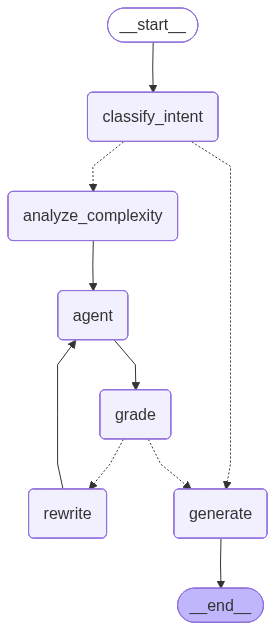

In [ ]:
# ============================================================================
# Modular Agentic RAG 그래프 빌드
# ============================================================================
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph.state import CompiledStateGraph
from typing import Literal

# ----------------------------------------------------------------------------
# 체크포인터 추가 (대화 이력 유지)
# ----------------------------------------------------------------------------
modular_rag_checkpointer = InMemorySaver()

# ----------------------------------------------------------------------------
# StateGraph 초기화
# ----------------------------------------------------------------------------
workflow = StateGraph(AgenticRAGState)

# ----------------------------------------------------------------------------
# 노드 추가
# ----------------------------------------------------------------------------
workflow.add_node("classify_intent", classify_intent_node)
workflow.add_node("analyze_complexity", analyze_complexity_node)
workflow.add_node("agent", agent_node)
workflow.add_node("grade", grade_node)
workflow.add_node("rewrite", rewrite_node)
workflow.add_node("generate", generate_node)
# ----------------------------------------------------------------------------
# 엣지 연결
# ----------------------------------------------------------------------------

# START → classify_intent
workflow.add_edge(START, "classify_intent")

# classify_intent → analyze_complexity 또는 generate (조건부)
def decide_after_intent(state: AgenticRAGState) -> Literal["analyze_complexity", "generate"]:
    """의도 분류 후 다음 노드 결정.
    
    Args:
        state: 현재 상태
        
    Returns:
        다음 노드 이름
    """
    intent = state.get("intent", "SEARCH")
    
    # GENERAL 의도면 검색 없이 바로 답변
    if intent == "GENERAL":
        print("  [ROUTE] GENERAL 의도 → generate로 직접 이동")
        return "generate"
    
    # 그 외는 RAG 워크플로우 진행
    return "analyze_complexity"

workflow.add_conditional_edges(
    "classify_intent",
    decide_after_intent,
    {
        "analyze_complexity": "analyze_complexity",
        "generate": "generate",
    }
)

# analyze_complexity → agent (항상)
workflow.add_edge("analyze_complexity", "agent")

# agent → grade (항상)
workflow.add_edge("agent", "grade")

# grade → generate 또는 rewrite (조건부)
def decide_after_grade(state: AgenticRAGState) -> Literal["generate", "rewrite"]:
    """문서 관련성 평가 후 다음 노드 결정.
    
    Args:
        state: 현재 상태
        
    Returns:
        다음 노드 이름
    """
    doc_grade = state.get("doc_grade", "no")
    rewrite_count = state.get("rewrite_count", 0)
    
    # 문서가 관련있으면 generate로
    if doc_grade == "yes":
        print("  [ROUTE] 문서 관련성 양호 → generate")
        return "generate"
    
    print(f"재작성 횟수: {rewrite_count}")
    
    return "rewrite"

workflow.add_conditional_edges(
    "grade",
    decide_after_grade,
    {
        "generate": "generate",
        "rewrite": "rewrite",
    }
)

# rewrite → agent (재검색 루프)
workflow.add_edge("rewrite", "agent")

# generate → END
workflow.add_edge("generate", END)

prod_workflow: CompiledStateGraph = workflow.compile(
    checkpointer=modular_rag_checkpointer,
)

prod_workflow

### 5.2 RAGAS 통합 평가

이제 `AgenticRAGEvaluator`를 사용하여 전체 평가 파이프라인을 실행합니다.

**워크플로우:**
1. 평가 데이터셋 준비
2. `AgenticRAGEvaluator.run_full_evaluation()`
3. RAGAS 점수 계산
4. `AutoImprovementEngine`으로 개선 계획 생성
5. 결과 분석 및 개선안 적용


In [ ]:
# ============================================================================
# Step 5: AgenticRAGEvaluator 초기화 및 평가 실행
# ============================================================================

print("=" * 80)
print("Step 5: RAGAS 통합 평가")
print("=" * 80)

# Evaluator 초기화
evaluator = AgenticRAGEvaluator(
    graph=prod_graph,
    llm=prod_llm,
    embeddings=prod_embeddings,
)

# 평가 데이터셋 재사용 (Section 3에서 생성한 것)
print(f"\n평가 데이터셋: {eval_dataset.name}")
print(f"  - 질문 수: {len(eval_dataset.questions)}개")

# 전체 평가 실행 (평가 + 개선 계획)
print("\n" + "=" * 80)
print("전체 평가 시작 (RAGAS + AutoImprovement)")
print("=" * 80)

try:
    report, improvement_plan = evaluator.run_full_evaluation(
        dataset=eval_dataset,
        config=config,
    )

    print("\n전체 평가 완료")

    # 평가 리포트 출력
    print("\n" + "=" * 80)
    print("RAGAS 평가 리포트")
    print("=" * 80)

    print("\n평균 점수:")
    for metric, score in report.average_scores.items():
        print(f"  • {metric.value:20s}: {score:.3f}")

    # 개선 계획 출력
    print("\n" + "=" * 80)
    print("자동 개선 계획")
    print("=" * 80)

    print(f"\n{improvement_plan.summary}")

    print("\n우선순위별 액션:")
    for action in improvement_plan.actions[:3]:  # 상위 3개
        print(f"\n  {action.priority.value.upper()}: {action.description}")
        print(f"    - 대상 노드: {action.target_node.value}")
        print(f"    - 목표 지표: {action.target_metric.value}")
        print(f"    - 예상 개선: +{action.expected_metric_improvement:.2%}")

except Exception as e:
    print(f"\n 평가 중 오류: {e}")
    import traceback
    traceback.print_exc()

## 6. 마무리 및 핵심 요약

### 6.1 학습 목표 달성

**1. Agentic RAG 구현**
- LangGraph StateGraph로 Intent → Complexity → Retrieve → Generate 워크플로우 구축
- LangChain v1 `create_agent` 패턴 적용
- Tool 기반 검색 (vector_search, web_search, query_rewrite 등)

**2. RAGAS 4대 지표 이해 및 평가**
- Context Precision/Recall, Faithfulness, Answer Relevancy 측정
- 노드별 지표 매핑 (Retrieval→Recall, Reranking→Precision 등)

**3. 프로덕션 패턴 적용**
- 미들웨어 (오류 처리, 로깅, 재귀 한도)
- 체크포인터 (대화 이력 유지)
- 모듈화 (tools.py, middleware.py, graph.py, evaluation.py)

**4. 자동 개선 엔진**
- RAGAS 결과 → 개선 액션 자동 생성
- 우선순위별 개선 계획 (CRITICAL/HIGH/MEDIUM/LOW)
- A/B 테스트 준비


### 6.2 핵심 아키텍처 패턴

```
[사용자 질문]
       ↓
[Intent Classification] ← 의도 파악
       ↓
[Complexity Analysis] ← 복잡도 분석
       ↓
[Agent (Tools)] ← 자율적 검색/실행
       ↓
[Grade Documents] ← 관련성 평가
       ↓
 (필요시) [Rewrite] → 재검색 루프
       ↓
[Generate Answer] ← 최종 답변
       ↓
[RAGAS Evaluation] ← 4대 지표 평가
       ↓
[AutoImprovement] ← 개선 계획 생성
```

### 6.3 실무 적용 가이드

**Phase 1: 기본 RAG 구축**
- Simple Vector Search → Hybrid Search
- 기본 프롬프트 엔지니어링

**Phase 2: Agentic RAG 도입**
- Intent Classification 추가
- Adaptive Retrieval (복잡도별 전략)
- Tool 기반 확장

**Phase 3: 평가 및 개선**
- RAGAS 4대 지표 정기 측정
- AutoImprovementEngine으로 병목 식별
- A/B 테스트로 개선 효과 검증

**Phase 4: 프로덕션 운영**
- LangFuse 등 LLMOps 도구로 추적/모니터링
- 체크포인터, Mem0 로 대화 이력, 장기메모리 관리
- 미들웨어로 안정성 강화
